In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import squarify

In [2]:
#Load Data
causal_lookup = pd.read_csv('dh_causal_lookup.csv')
product_lookup = pd.read_csv('dh_product_lookup.csv')
store_lookup = pd.read_csv('dh_store_lookup.csv')
transactions = pd.read_csv('dh_transactions.csv')

# Exploratory Data Analysis

### Data Quality Verification

In [3]:
#Function สำหรับการเช็คค่าทางสถิติและดูภาพรวมของข้อมูลเพื่อทำความเข้าใจข้อมูลให้มากยิ่งขึ้น
def summarize_dataframe(df):
    summary_data = []

    for column in df.columns:
        data_type = df[column].dtype
        unique_values_count = df[column].nunique()
        value_counts = df[column].value_counts()
        missing_values_count = df[column].isnull().sum()
        
        # คำนวณ Min, Max, Mean และแปลงค่าเป็นเลขฐาน 10
        if pd.api.types.is_numeric_dtype(df[column]):
            min_value = round(df[column].min())
            max_value = round(df[column].max())
            mean_value = round(df[column].mean())
            median_value = round(df[column].median())
            std_value = round(df[column].std())

            # สร้างคอลัมน์ Range
            range_value = f"{min_value:.10g} - {max_value:.10g}"
            
            # แปลง Mean ให้อยู่ในเลขฐาน 10
            mean_value = f"{mean_value:.10g}"
            
            # แปลง Mean ให้อยู่ในเลขฐาน 10
            median_value = f"{median_value:.10g}"
            
            # แปลง Mean ให้อยู่ในเลขฐาน 10
            std_value = f"{std_value:.10g}"

        else:
            range_value = None
            mean_value = None
            median_value = None
            std_value = None
        
        # คำนวณ Outliers
        if pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            count_lower_outliers = df[df[column] < lower_bound].shape[0]
            count_upper_outliers = df[df[column] > upper_bound].shape[0]
        else:
            count_lower_outliers = None
            count_upper_outliers = None

        # ตัวอย่างข้อมูลในแต่ละค่า
        examples = value_counts.index.tolist()[:5]
        
        # นับจำนวนในแต่ละค่า
        #counts = value_counts.tolist()[:2]
        
        summary_data.append({
            'Attribute': column,
            'Data Type': data_type,
            'Row' : len(df),
            'Unique Values': unique_values_count,
            'Missing Values': missing_values_count,
            'Range (Min - Max)': range_value,
            'Mean': mean_value,
            'Medium' : median_value,
            'STD' : std_value,
            'Lower Outliers Count': count_lower_outliers,
            'Upper Outliers Count': count_upper_outliers,
            'Values': examples,
            #'Counts': counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    return summary_df

#ตรวจสอบความถูกต้องและสอดคล้องของข้อมูล จะคืนค่าเป็น records ที่ไม่สอดคล้อง
def get_non_matching_records(df1, attrA, df2, attrB):
    non_matching = df1[~df1[attrA].isin(df2[attrB])]
    
    return non_matching

#หาpattern ข้อมูลค่าใน Attr และหา Error
def detect_patterns(df, column):
    # เก็บรูปแบบที่พบในคอลัมน์
    patterns = []

    for value in df[column].dropna():
        # แปลงค่าทั้งหมดให้เป็นสตริง
        value_str = str(value)
        
        # หารูปแบบทั่วไปโดยการแทนที่ตัวเลขด้วย "D" และตัวอักษรด้วย "A"
        pattern = re.sub(r'\d', 'D', value_str)
        pattern = re.sub(r'[a-zA-Z]', 'A', pattern)
        pattern = re.sub(r'\s+', ' ', pattern)  # ลบช่องว่างที่เกินมา
        
        patterns.append(pattern)
    
    # นับความถี่ของแต่ละรูปแบบ
    pattern_counts = Counter(patterns)
    
    # สร้าง DataFrame ที่มีคอลัมน์ 'patterns' และ 'count'
    pattern_df = pd.DataFrame(pattern_counts.items(), columns=['patterns', 'count'])
    
    return pattern_df


#คืน records ที่มีต่าตรกับ Pattern ที่ใส่เข้าไป
def filter_by_pattern(df, column, pattern):
    # สร้างฟังก์ชันภายในเพื่อแปลงค่าของคอลัมน์เป็นรูปแบบเดียวกันกับ detect_patterns
    def revert_pattern(value):
        value_str = str(value)
        revert_pattern = re.sub(r'\d', 'D', value_str)
        revert_pattern = re.sub(r'[a-zA-Z]', 'A', revert_pattern)
        revert_pattern = re.sub(r'\s+', ' ', revert_pattern)
        return revert_pattern
    
    # กรอง records ที่มี pattern ตรงกับที่กำหนด
    matching_records = df[df[column].apply(revert_pattern) == pattern]
    
    return matching_records


def convert_time_of_transaction(df, column):
    # แปลงค่า time_of_transaction เป็นรูปแบบเวลา HH:MM
    df[column] = df[column].apply(lambda x: f"{int(x // 100):02}:{int(x % 100):02}")
    return df

In [4]:
#ดูรายละเอียด
causal_summary = summarize_dataframe(causal_lookup)
product_summary = summarize_dataframe(product_lookup)
store_summary = summarize_dataframe(store_lookup)
transactions_summary = summarize_dataframe(transactions)

#### causal_summary

In [5]:
causal_summary

,Attribute,Data Type,Row,Unique Values,Missing Values,Range (Min - Max),Mean,Medium,STD,Lower Outliers Count,Upper Outliers Count,Values
0,upc,int64,351372,479,0,601011292 - 9999985766,6107930574,5100001214,2881551470,0.0,0.0,"[3620000300, 3620000250, 3620000350, 999998505..."
1,store,int64,351372,381,0,1 - 387,192,191,111,0.0,0.0,"[270, 187, 152, 326, 333]"
2,week,int64,351372,62,0,43 - 104,70,68,18,0.0,0.0,"[67, 68, 79, 44, 49]"
3,feature_desc,object,351372,8,0,None,None,None,None,NaN,NaN,"[Interior Page Feature, Not on Feature, Front ..."
4,display_desc,object,351372,11,0,None,None,None,None,NaN,NaN,"[Not on Display, Rear End Cap, In-Shelf, Secon..."
5,geography,int64,351372,2,0,1 - 2,1,1,0,0.0,0.0,"[1, 2]"


In [6]:
#upc : ตรวจสอบความถูกต้อง(Completeness)และสอดคล้องของข้อมูล(Consistency) Check upc.causal : upc.product 
upc_non_matching = get_non_matching_records(causal_lookup, 'upc', product_lookup, 'upc')
upc_non_matching #ข้อมูลสอดคล้องทั้งหมด

,upc,store,week,feature_desc,display_desc,geography


In [7]:
#store : ตรวจสอบความถูกต้องของและสอดคล้องของข้อมูล Check store.causal : 
store_non_matching = get_non_matching_records(causal_lookup, 'store', store_lookup, 'store')
store_non_matching #ข้อมูลสอดคล้องทั้งหมด

,upc,store,week,feature_desc,display_desc,geography


In [8]:
#feature_desc : ความถูกต้องของรูปแบบ(Validity) เช็ค error Value : counts
patterns_feature_desc = detect_patterns(causal_lookup, 'feature_desc')
patterns_feature_desc #คืนค่าเป็นตารางและดูจาก Count จะได้ว่าไม่มีความผิดปกติของข้อมูล

,patterns,count
0,AAAA AAAAAAAA AAAAAAA,22203
1,AAAA AAAA AAAAAAA,12401
2,AAAAAAAA AAAA AAAAAAA,192995
3,AAA AA AAAAAAA,78955
4,AAAAAAAA AAAA AAAA AAAA,6001
5,AAAA AAAAA AAAAAAA,4768
6,AAAAA AAAA AAAAAAA,34049


In [9]:
#display_desc : ความถูกต้องของรูปแบบ เช็ค error Value : counts
patterns_display_desc = detect_patterns(causal_lookup, 'display_desc')
patterns_display_desc

,patterns,count
0,AAA AA AAAAAAA,254776
1,AAAA AAA AAA,24656
2,AAAAA AAAA,4250
3,AAAAA AAA AAA,10178
4,AA-AAAAA,29764
5,AAAAA AAAAA,2257
6,AAAAAAAAA AAAAAAAA AAAAAAA,14475
7,AAAAA/AAAAAAAA AAAAA,5329
8,AAAA-AAAAA AAA AAA,1012
9,AAA-AAAAA AAA AAA,4675


#### product_summary

In [10]:
product_summary

,Attribute,Data Type,Row,Unique Values,Missing Values,Range (Min - Max),Mean,Medium,STD,Lower Outliers Count,Upper Outliers Count,Values
0,upc,int64,927,927,0,111112360 - 9999985766,5534601767,5100005043,2754209377,0.0,0.0,"[111112360, 7130000088, 7130000124, 7130000126..."
1,product_description,object,927,872,0,None,None,None,None,NaN,NaN,"[PRIVATE LABEL ELBOW MACARONI, PRIVATE LABEL S..."
2,commodity,object,927,4,0,None,None,None,None,NaN,NaN,"[pasta, pasta sauce, syrups, pancake mixes]"
3,brand,object,927,131,0,None,None,None,None,NaN,NaN,"[Private Label, Barilla, Ragu, Private Label P..."
4,product_size,object,927,146,0,None,None,None,None,NaN,NaN,"[16 OZ, 26 OZ, 12 OZ, 24 OZ, 8 OZ]"


1) upc

    - ตรวจสอบความถูกต้องของรูปแบบ(Validity) : Pattern 
    - เป็น Primary มี Uniqueness (ความเป็นเอกลักษณ์) จากการที่มี Row = Unique Values
    - Data Type Check
    
2) product_description : ไม่น่าต้องตรวจอะไร 

3) commodity:
    - ตรวจสอบความถูกต้อง
    
4) brand: ไม่น่าต้องตรวจอะไร

5) product_size: 
    - ตรวจสอบความถูกต้องของรูปแบบ : Pattern

In [11]:
#upc : ตรวจสอบความถูกต้องของรูปแบบ(Validity) : Pattern 
patterns_upc = detect_patterns(product_lookup, 'upc')
patterns_upc #ด้วยความที่ patterns 0 มันมีน้อยก็จริง แต่ก็ยังเป็น Unique Values ตอน print ออกมาดูก็ไม่รู้ว่าตั้งใจหรือว่ามีความเกี่ยวข้องอย่างไร แต่โดยรวมมันไม่ได้มีปัญหาในแง่การใช้งานขนาดนั้นเลยไม่ได้แก้

,patterns,count
0,AAAAAAAAA,27
1,AAAAAAAAAA,900


In [12]:
#commodity : ตรวจสอบความถูกต้อง
patterns_commodity = detect_patterns(product_lookup, 'commodity')
patterns_commodity

,patterns,count
0,AAAAA AAAAA,294
1,AAAAAA,139
2,AAAAA,448
3,AAAAAAA AAAAA,46


In [13]:
#product_size: ตรวจสอบความถูกต้องของรูปแบบ : Pattern
patterns_product_size = detect_patterns(product_lookup, 'product_size')
patterns_product_size.sort_values(by=['count'])

,patterns,count
31,%AA# AAAAA,1
30,AA.A AA AA,1
14,AA A/A AA,1
20,A AA AA AA,1
17,A A/A AA,1
7,AA A,1
22,AA.AAA,1
25,A AAAAA,1
26,.AA AA,1
27,%AA# AAAA,1


In [14]:
#Analyst เพื่อหาความผิดพลาด เพื่อแก้ไข
filtered_product_size = pd.DataFrame()
YYYYYYYYYY = ['%AA# AAAAA', 'AA.A AA AA', 'AA A/A AA', 'A AA AA AA', 'A A/A AA','AA A', 'AA.AAA', 'A AAAAA', '.AA AA', '%AA# AAAA', 'AAAA AAAAA','AAAA AAAA', 'AA AAA', 'AA.A', 'AA AA AAA', 'AAA', ' ', 'AA AA.','A.AA AA', '##########', 'A A AA', 'AA AAAAA', 'AA# AAAA','AA AA AA', 'A AA AA', 'AA# AAAAA', 'AAAA']
for i in YYYYYYYYYY:
    filtered_product_size = pd.concat([filtered_product_size, filter_by_pattern(product_lookup, 'product_size', i)])
    print(filter_by_pattern(product_lookup, 'product_size', i).to_string())
    print('---------------------------------------------------------------')


            upc        product_description    commodity brand product_size
789  8935363153  M C ARRIBIATA SAUCE 26 OZ  pasta sauce   M C   %KH# 29483
---------------------------------------------------------------
            upc        product_description    commodity          brand product_size
781  8634157120  SLVR PAL\BALSAMCO VINEGAR  pasta sauce  Silver Palate   12.5 FL OZ
---------------------------------------------------------------
            upc      product_description    commodity     brand product_size
140  2472200005  ANNARINO MUSHROOM SAUCE  pasta sauce  Annarino    31 1/2 OZ
---------------------------------------------------------------
            upc        product_description    commodity brand product_size
279  3620000661  RAGU TRAD SPAGH SCE PLAIN  pasta sauce  Ragu   6 LB 11 OZ
---------------------------------------------------------------
            upc       product_description      commodity       brand product_size
201  3250041100  WHT LILY BLUBRY PNCK MI

In [15]:
#Delete Records ที่มี Patterns ตามนี้ทิ้ง เพราะไม่สามารถแก้ได้
filtered_product_size_for_Delete = pd.DataFrame()
YYYYYYYYYY_for_Delete = ['AA.A AA AA' , '.AA AA', '%AA# AAAA', 'AAAA AAAAA','AAAA AAAA', 'AA AAA', 'AAA', ' ', '##########','AA# AAAA', 'AA# AAAAA']

for i in YYYYYYYYYY_for_Delete:
    filtered_product_size_for_Delete = pd.concat([filtered_product_size_for_Delete, filter_by_pattern(product_lookup, 'product_size', i)])
#filtered_product_size_for_Delete


def remove_matching_records(df1, df2):
    merged_df = pd.merge(df1, df2, how='inner')
    non_matching_df = pd.concat([df1, merged_df]).drop_duplicates(keep=False)
    
    return non_matching_df

product_lookup_after_remove = remove_matching_records(product_lookup, filtered_product_size_for_Delete)
product_lookup_after_remove
#product_lookup = product_lookup_after_remove
#product_lookup

,upc,product_description,commodity,brand,product_size
0,111112360,VINCENT S ORIG MARINARA S,pasta sauce,Vincent's,25 OZ
1,566300023,PINE MOUNTAIN SYRUP,syrups,Pine Mountain,40 OZ
2,566300028,MILLER CANE SYRUP,syrups,Miller,19 OZ
3,566300029,MILLER CANE SYRUP,syrups,Miller,12 OZ
4,566300035,PINE MOUNTAIN SYRUP,syrups,Pine Mountain,19 OZ
...,...,...,...,...,...
922,9999985217,PRIVATE LABEL ALPHABETS,pasta,Private Label,16 OZ
923,9999985260,PRIVATE LABEL COMPLETE PANCAKE MIX,pancake mixes,Private Label,32 OZ
924,9999985261,PRIVATE LABEL COMPLETE PANCAKE MIX,pancake mixes,Private Label,2 LB
925,9999985488,PRIVATE LABEL ITAL NESTED ANGEL HAIR,pasta,Private Label Premium,16 OZ


In [16]:
#Replace ข้อมูลที่สามารถแก้ไขได้ หลักๆจะเป็นการแก้ไข Format เช่น 24OZ -> 24 OZ หรือแก้ไขคำผิด เช่น ' Z': ' OZ' แต่จะมีบางข้อมูลที่ทำการแปลงหน่วยเพื่อความเป็นเอกภาพของข้อมูล เช่น 'FL OZ': 'OZ'
def convert_to_oz(text):
    # แปลง FL OZ เป็น OZ ด้วยการคูณด้วย 1.04
    text = re.sub(r'(\d+(\.\d+)?)\s*FL\s*OZ', lambda m: f"{round(float(m.group(1)) * 1.04)} OZ", text)

    # แปลง LB เป็น OZ ด้วยการคูณด้วย 16 และรวมกับ OZ เดิม
    text = re.sub(r'(\d+)\s*LB\s*(\d+)?\s*OZ', lambda m: f"{int(m.group(1)) * 16 + (int(m.group(2)) if m.group(2) else 0)} OZ", text)

    # แปลงเฉพาะ LB เป็น OZ ด้วยการคูณด้วย 16
    text = re.sub(r'(\d+)\s*LB', lambda m: f"{int(m.group(1)) * 16} OZ", text)
    
    return text

def clean_text(text):
    # แปลง FL OZ และ LB เป็น OZ ก่อน
    text = convert_to_oz(text)

    # แทนที่เศษส่วน เช่น 6 1/2 เป็นค่าทศนิยม เช่น 6 1/2 -> 6.5
    text = re.sub(r'(\d+)\s*1/2', lambda m: f"{float(m.group(1)) + 0.5}", text)
    
    # เพิ่มช่องว่างระหว่างตัวเลขและตัวอักษร (เช่น 24OZ -> 24 OZ)
    text = re.sub(r'(\d)([A-Za-z])', r'\1 \2', text)
    
    # แก้ไขรูปแบบตัวอักษรอื่นๆ ตามเงื่อนไขที่ให้มา
    replacements = {
        ' Z': ' OZ',
        'OUNCE': 'OZ',
        'OZ.': 'OZ',
        'FMLY': 'OZ',
        ' CR': '',
        ' P ': '',
        'FL OZ': 'OZ'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)

    # เพิ่มช่องว่างที่ถูกต้อง
    text = re.sub(r'\s+', ' ', text).strip()

    # ตรวจสอบว่าค่าที่มีแต่ตัวเลข เช่น 11.6 ต้องเติม OZ ต่อท้าย
    if re.match(r'^\d+(\.\d+)?$', text):
        text += ' OZ'
    
    return text

def clean_column(df, column):
    df[column] = df[column].apply(clean_text)
    return df

product_lookup_cleaned_df = clean_column(product_lookup, 'product_size')
product_lookup_cleaned_df
product_lookup = product_lookup_cleaned_df
product_lookup

,upc,product_description,commodity,brand,product_size
0,111112360,VINCENT S ORIG MARINARA S,pasta sauce,Vincent's,25 OZ
1,566300023,PINE MOUNTAIN SYRUP,syrups,Pine Mountain,40 OZ
2,566300028,MILLER CANE SYRUP,syrups,Miller,19 OZ
3,566300029,MILLER CANE SYRUP,syrups,Miller,12 OZ
4,566300035,PINE MOUNTAIN SYRUP,syrups,Pine Mountain,19 OZ
...,...,...,...,...,...
922,9999985217,PRIVATE LABEL ALPHABETS,pasta,Private Label,16 OZ
923,9999985260,PRIVATE LABEL COMPLETE PANCAKE MIX,pancake mixes,Private Label,32 OZ
924,9999985261,PRIVATE LABEL COMPLETE PANCAKE MIX,pancake mixes,Private Label,32 OZ
925,9999985488,PRIVATE LABEL ITAL NESTED ANGEL HAIR,pasta,Private Label Premium,16 OZ


#### store_summary

In [17]:
store_summary

,Attribute,Data Type,Row,Unique Values,Missing Values,Range (Min - Max),Mean,Medium,STD,Lower Outliers Count,Upper Outliers Count,Values
0,store,int64,387,387,0,1 - 387,194,194,112,0,0,"[1, 291, 265, 264, 263]"
1,store_zip_code,int64,387,299,0,29063 - 62966,35450,31545,6677,0,11,"[37211, 40502, 30064, 30024, 37064]"


1) store: 

    - ตรวจสอบความซ้ำซ้อน Uniqueness (ความเป็นเอกลักษณ์): Row = Unique Values
    - Data Type
    
2) store_zip_code: ไม่น่ามีไร

#### transactions_summary

In [18]:
transactions_summary

,Attribute,Data Type,Row,Unique Values,Missing Values,Range (Min - Max),Mean,Medium,STD,Lower Outliers Count,Upper Outliers Count,Values
0,upc,int64,5197681,927,0,111112360 - 9999985766,6203548089,5100012910,3152023380,0,0,"[9999985020, 9999985004, 9999985068, 362000025..."
1,dollar_sales,float64,5197681,1502,0,-12 - 153,2,2,1,230,193240,"[0.99, 1.99, 1.5, 1.19, 0.79]"
2,units,int64,5197681,49,0,1 - 156,1,1,1,0,821688,"[1, 2, 3, 4, 5]"
3,time_of_transaction,int64,5197681,1440,0,0 - 2359,1544,1602,385,57000,0,"[1734, 1739, 1728, 1752, 1743]"
4,geography,int64,5197681,2,0,1 - 2,1,1,0,0,0,"[1, 2]"
5,week,int64,5197681,104,0,1 - 104,53,55,30,0,0,"[79, 27, 63, 77, 12]"
6,household,int64,5197681,510027,0,1 - 510027,223138,209694,141216,0,0,"[59972, 108965, 265319, 293395, 56869]"
7,store,int64,5197681,387,0,1 - 387,202,209,112,0,0,"[270, 359, 71, 322, 371]"
8,basket,int64,5197681,3316349,0,1 - 3316349,1662961,1666884,959319,0,0,"[304689, 564677, 2749468, 2260779, 2149969]"
9,day,int64,5197681,726,0,1 - 728,370,380,210,0,0,"[553, 189, 559, 441, 547]"


1) upc : pc.Transactions : upc.product
    
2) dollar_sales : อาจมี Error ที่รายการติดลบ
    
3) units : non

4) time_of_transaction : น่าจะเป็นเวลาจาก 00:00 - 23:59 จากที่มี Unique Values = 1440 และ Range (Min - Max) = 0 - 2359, check Data Type
    
5) geography : non

6) week : non

7) household : ตรวจสอบความถูกต้องของรูปแบบ Validity
    
8) store : ตรวจสอบความถูกต้องของข้อมูล Check store.transactions : store.store
    
9) basket : ตรวจสอบความถูกต้องและความสัมพันธ์อาจมีการนับซ้ำกันแบบต่างสาขา
    
10) day : non

11) coupon : non

In [19]:
#upc : upc.Transactions : upc.product
upc_non_matching = get_non_matching_records(transactions, 'upc', product_lookup, 'upc')
upc_non_matching

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon


In [20]:
#dollar_sales ไม่ควรต่ำกว่า 0
transactions[transactions['dollar_sales'] < 0]

transactions = remove_matching_records(transactions, transactions[transactions['dollar_sales'] < 0])
transactions

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon
0,7680850106,0.80,1,1100,2,1,125434,244,1,1,0
1,3620000470,3.59,1,1100,2,1,125434,244,1,1,0
2,1800028064,2.25,1,1137,2,1,108320,244,2,1,0
3,9999985067,0.85,1,1148,2,1,162016,244,3,1,0
4,9999985131,2.19,1,1323,2,1,89437,244,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5197676,9999985001,0.39,1,2354,1,104,435465,199,3316346,728,0
5197677,9999966720,1.05,1,2354,1,104,435465,199,3316346,728,0
5197678,9999985027,0.99,1,2311,1,104,352690,218,3316347,728,0
5197679,3620000300,1.53,1,2245,1,104,55530,93,3316348,728,0


In [21]:
#household : ตรวจสอบความถูกต้องของรูปแบบ Validity
patterns_household = detect_patterns(transactions, 'household')
patterns_household

,patterns,count
0,AAAAAA,3885157
1,AAAAA,1187644
2,AAAA,110866
3,AAA,8923
4,AA,416
5,A,171


In [22]:
#store : ตรวจสอบความถูกต้องของข้อมูล Check store.transactions : store.store
store_non_matching = get_non_matching_records(transactions, 'store', store_lookup, 'store')
store_non_matching

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon


In [23]:
#Check ว่ามี Basket ที่บันทึกกันแบบต่างสาขาหรือไม่

def check_invalid_pairs(df, attr1, attr2):
    # สร้าง DataFrame เพื่อหาคู่ที่ไม่ซ้ำกันและนับจำนวน
    pair_counts = df.groupby(attr2)[attr1].nunique()
    
    # ตรวจสอบว่ามีคู่ใดบ้างที่ attr2 จับคู่กับ attr1 มากกว่า 1 ค่า
    invalid_pairs = pair_counts[pair_counts > 1]
    
    if not invalid_pairs.empty:
        return invalid_pairs
    else:
        print("None")
        return None


invalid_pairs = check_invalid_pairs(transactions, 'store', 'basket')

if invalid_pairs is not None:
    print(invalid_pairs)

None


## How is the data quality?

ถ้าวัดตามค่าเชิงสถิติ 
-	ค่าเฉลี่ย (Mean), มัธยฐาน (Median),ค่าสูงสุด (Max),ค่าต่ำสุด (Min),ส่วนเบี่ยงเบนมาตรฐาน (Standard Deviation) เหล่านี้ล้วนไม่มีปัญหา

ถ้าวัดตามตัวชี้วัดต่าง ๆ จะมีข้อสังเกตุบางอย่างดังนี้
1. Completeness (ความครบถ้วน)
    -	Missing Value: ไม่มีเลย แต่หมายถึงแค่ไม่มีค่าว่างเฉย ๆ
    -	ความต่อเนื่องและเพียงพอของข้อมูลค่อนข้างน้อยเมื่อทำการ Aggregate เช่น ข้อมูล week ของบางตารางไม่ครบ ข้อมูล display_desc ส่วนใหญ่ไม่มีค่า ยิ่งถ้าเป็นการเรียกดูรายสัปดาห์จะพบว่าข้อมูลในส่วนนี้ไม่ค่อยมี
    -	ความครบถ้วนของ Attr เช่น มีความเป็นไปได้ที่ records ที่มี dollar_sales ติดลบอาจเกิดจากการคืนสินค้าหรือกรณีอื่นๆ เพราะปกติไม่น่ามี Transaction ไหนที่จะมีค่าติดลบ

2. Accuracy (ความถูกต้อง)
    -	ไม่มี Missing Value ก็จริงแต่มีข้อมูลที่ผิดอยู่ประมาณหนึ่ง โดยเฉพาะใน product_size ในตาราง product_lookup 
    -	ไม่มีข้อมูลแน่ชัดในการตรวจสอบพวก store_zip_code, geography
    -	ไม่มี Meta Data ให้ตรวจสอบ
    -	ค่า dollar_sales ใน transactions มีบางค่าติดลบ มีความไม่แน่นอนถึงสาเหตุ
    -	มีค่า outlier. ก็จริงแต่เป็น Positive Outlier
3. Consistency (ความสม่ำเสมอ)
-	Pattern : ไม่ชัดเจน เช่น 
        o	 upc เป็น Uniquen Value และไม่มีค่าซ้ำกันก็จริงแต่ Pattern ไม่ได้เหมือนกันทั้งหมด ซึ่งอาจจะมีปัญหาในการเช็คความถูกต้องการการจัดการข้อมูลสินค้าในภายหลัง
        o	Product_size : นอกจากค่าที่ผิดแล้วยังมีหลายหน่วยวัดอีก เช่น OZ , FL OZ, GEL 
        o	การเก็บ product_description บางค่าจะมีการรวม Product_size ไว้ในชื่อด้วย 
        o	พวก Uniqueness หลายๆตัวเก็บมาเป็น int ทำให้มีปัญหาเรื่อง Pattern, Data type
4. Uniqueness (ความเป็นเอกลักษณ์)
    -	Upc ไม่ได้มี pattern เดียว
    -	product_description มีค่าที่ซ้ำกัน
5. Timeliness 
    -	มีปัญหาเรื่องที่ข้อมูลไม่ครบ
6. Validity (ความถูกต้องตามกฎที่กำหนด)
    -	ในกรณีที่ไม่มีเหตุผลลองรับ การมีค่า dollar_sales ใน transactions บางค่าติดลบ ก็ถือว่าผิด Validity นะ
    -	time_of_transaction เก็บในรูปแบบที่ม่ใช่เวลา
    -   ยอดขายของร้านค้า อย่างบางร้านขายได้เฉลี่ยนสัปดาห์ละไม่ถึง 100 dollar อันที่จริงก็ไม่รู้ว่านี่มันผิดปกติไหมด้วยซ้ำ
7. Integrity (ความสมบูรณ์ของความสัมพันธ์ในข้อมูล)
    -   ความสัมพันธ์ระหว่างข้อมูลสมยูรณ์ในแง่ของความถูกต้อง เช่น คีย์ ในการเชื่อมแต่ละตาราง ครบถ้วนสมบูรณ์ไม่อะไรต้องแก้ไขปรับปรุงแต่ ความสัมพันธ์ของข้อมูลที่แยกลึกลงไปค่อนข้างแย่ ส่วนมากเกิดจากปัญหาข้อมูลไม่เพียงพอ และไม่ครบถ้วน เพราะข้อมูลดูเหมือนเยอะ แต่พอแยกมาดูทีละส่วนจะพบว่ามันขาดหายไปพอสมควร


การสรุปผลคุณภาพของข้อมูล:

ถึงจะมีส่วนที่ต้องแก้ไขบ้างแต่โดยรวมถ้าไม่นับปัญหาเรื่องที่ข้อมูลไม่ครบถ้วนและเรื่องที่มีข้อมูลที่มีความผิดพลาด ส่วนใหญ่จะเป็นปัญหายิบย่อย บางอย่างอาจจะไม่ใช่ปัญหาด้วยซ้ำเพียงแต่เราไม่รู้เหตุผลของคนทำชุดข้อมูล ไม่ได้มี Meta Data ที่จะวิเคราะห์ อย่างเช่น เรื่องที่ upc ไม่ได้มี pattern เดียว แต่เป็น Unique Value มันไม่ได้มีปัญหาเรื่องของการวิเคราะห์หรือทำให้เกิดข้อผิดพลาดอะไร หรือเรื่อง data type หลายๆ Attr มันอาจจะทำมาเพื่อสิเคราะห์มากกว่าทำฐานข้อมูลก็ได้ 
กลับกันความครบถ้วน ความถูกต้อง และโดยเฉพาะความสอดคล้องของข้อมูลส่วนใหญ่ นั้นถูกต้องและมีคุณภาพมาก เรียกได้ว่านอกจากข้อมูลที่มีการใส่ค่ามาผิด ข้อมูลเกือบทั้งหมดเป็นข้อมูลที่มีคุณภาพเพียงพอแล้ว ดังนั้น คุณภาพโดยรวมของข้อมูลค่อนข้างดี เพียงแต่ยังขาดข้อมูลบางอย่างหรือขาดการอธิบายเพียงเท่านั้น 

# More data for Visaulization

DataFrame:transactions_combine_by_household

In [25]:
transactions_combine_by_household = transactions.groupby('household').agg(total_sales=('dollar_sales', 'sum'),                        
                                          total_unit=('units', 'sum'),                                       
                                          min_time_of_transaction=('time_of_transaction', 'min'),     
                                          max_time_of_transaction=('time_of_transaction', 'max'),     
                                          geography=('geography', 'mean'),                            
                                          store=('store', pd.Series.nunique),                         
                                          basket_n=('basket', pd.Series.nunique),                     
                                          first_day=('day', 'min'),                                   
                                          Last_day=('day', 'max'),                                    
                                          coupon=('coupon', 'mean')                                  
                                        ).reset_index()

transactions_combine_by_household

,household,total_sales,total_unit,min_time_of_transaction,max_time_of_transaction,geography,store,basket_n,first_day,Last_day,coupon
0,1,23.00,17,1030,2253,1.0,3,11,35,728,0.000000
1,2,343.74,155,652,2219,2.0,3,88,26,728,0.014599
2,3,5.28,2,1744,1744,1.0,1,1,322,322,0.000000
3,4,2.85,3,1251,1940,1.0,1,2,420,584,0.000000
4,5,9.83,6,1522,2052,2.0,1,3,69,263,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
509981,510023,12.95,9,1157,2031,1.0,1,5,123,634,0.000000
509982,510024,2.34,1,1309,1309,1.0,1,1,219,219,0.000000
509983,510025,3.25,3,1909,2039,1.0,1,2,452,601,0.000000
509984,510026,8.59,3,1031,1320,2.0,1,3,222,402,0.000000


In [26]:
#transactions_combine_by_household_summary = summarize_dataframe(transactions_combine_by_household)
#transactions_combine_by_household_summary

DataFrame : transactions_combine_by_basket

In [27]:
key_columns = ['store', 'basket', 'time_of_transaction', 'geography', 'week', 'household', 'day']
transactions_combine_by_basket = transactions.groupby(key_columns).agg({'upc': lambda x: list(x), 
                                                     'dollar_sales': 'sum',    
                                                    }).reset_index()
transactions_combine_by_basket = transactions_combine_by_basket.drop(columns=['units', 'coupon'], errors='ignore')
transactions_combine_by_basket

,store,basket,time_of_transaction,geography,week,household,day,upc,dollar_sales
0,1,223050,822,1,1,31932,1,[9999985133],0.78
1,1,223051,1030,1,1,245712,1,[3000005300],4.58
2,1,223052,1031,1,1,282188,1,[3620000444],1.99
3,1,223053,1214,1,1,242208,1,"[5100002549, 9999985027, 5100001588]",10.35
4,1,223054,1243,1,1,349190,1,"[3620000444, 9999985005]",5.17
...,...,...,...,...,...,...,...,...,...
3315528,387,3316120,1725,1,104,505079,726,[9999985070],0.69
3315529,387,3316121,1805,1,104,505842,726,"[3620001397, 1510000163]",4.68
3315530,387,3316122,1818,1,104,508052,726,[2920000212],0.99
3315531,387,3316123,2029,1,104,508020,726,"[6738703055, 9505900020, 6738703009]",6.57


DataFrame : totel_store_by_week

In [28]:
totel_store_by_week = transactions.groupby(['store', 'week']).agg(
        totel_customer=('household', pd.Series.nunique),         
        totel_basket=('basket', pd.Series.nunique),              
        totel_dollar_sales=('dollar_sales', 'sum'),              
        geography=('geography', 'mean'),                         
        totel_units=('units', 'sum')                             
    ).reset_index()

totel_store_by_week = totel_store_by_week.sort_values(by=['store', 'week'])
totel_store_by_week

,store,week,totel_customer,totel_basket,totel_dollar_sales,geography,totel_units
0,1,1,67,70,184.57,1.0,126
1,1,2,70,73,181.18,1.0,120
2,1,3,89,92,236.44,1.0,167
3,1,4,83,85,233.64,1.0,165
4,1,5,83,87,267.68,1.0,175
...,...,...,...,...,...,...,...
38769,386,104,108,110,351.64,1.0,207
38770,387,101,63,65,152.00,1.0,125
38771,387,102,81,86,230.30,1.0,162
38772,387,103,82,83,234.59,1.0,159


DataFrame : totel_store

In [29]:
totel_store = transactions.groupby('store').agg(
        totel_customer=('household', pd.Series.nunique),        
        totel_basket=('basket', pd.Series.nunique),             
        totel_dollar_sales=('dollar_sales', 'sum'),             
        geography=('geography', 'mean'),                        
        totel_units=('units', 'sum')                            
    ).reset_index()

totel_store = totel_store.sort_values(by=['store'])
totel_store

,store,totel_customer,totel_basket,totel_dollar_sales,geography,totel_units
0,1,1624,7806,20762.07,1.0,14678
1,2,2728,8878,23251.75,1.0,16171
2,3,2178,9407,26522.76,1.0,18286
3,4,1461,6351,16259.68,1.0,11029
4,5,2844,12030,32112.83,1.0,22783
...,...,...,...,...,...,...
382,383,2732,10505,28980.47,2.0,18562
383,384,953,4655,11782.05,2.0,8418
384,385,589,1587,4056.62,2.0,2832
385,386,879,1480,4147.81,1.0,2803


DataFrame : totel_product_sales

In [30]:
# คำนวณผลรวมของ dollar_sales และ units จาก transactions โดยใช้ upc เป็นคีย์
totel_product_sales = transactions.groupby('upc').agg(
        totel_sales=('dollar_sales', 'sum'),   
        totel_unite=('units', 'sum')           
    ).reset_index()

# รวมข้อมูลจาก product_lookup และผลรวมจาก transactions โดยใช้ upc เป็นคีย์หลัก
totel_product_sales = pd.merge(product_lookup, totel_product_sales, on='upc', how='left')

# แทนที่ค่า NaN ด้วย 0 ในกรณีที่ไม่มีข้อมูลยอดขายใน transactions
totel_product_sales['totel_sales'].fillna(0, inplace=True)
totel_product_sales['totel_unite'].fillna(0, inplace=True)

totel_product_sales

/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_1066/1716353139.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  totel_product_sales['totel_sales'].fillna(0, inplace=True)
/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_1066/1716353139.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting v

,upc,product_description,commodity,brand,product_size,totel_sales,totel_unite
0,111112360,VINCENT S ORIG MARINARA S,pasta sauce,Vincent's,25 OZ,184.68,32.0
1,566300023,PINE MOUNTAIN SYRUP,syrups,Pine Mountain,40 OZ,231.93,67.0
2,566300028,MILLER CANE SYRUP,syrups,Miller,19 OZ,3446.55,1185.0
3,566300029,MILLER CANE SYRUP,syrups,Miller,12 OZ,2.98,2.0
4,566300035,PINE MOUNTAIN SYRUP,syrups,Pine Mountain,19 OZ,33.25,15.0
...,...,...,...,...,...,...,...
922,9999985217,PRIVATE LABEL ALPHABETS,pasta,Private Label,16 OZ,2236.47,2644.0
923,9999985260,PRIVATE LABEL COMPLETE PANCAKE MIX,pancake mixes,Private Label,32 OZ,28656.61,22898.0
924,9999985261,PRIVATE LABEL COMPLETE PANCAKE MIX,pancake mixes,Private Label,32 OZ,44963.78,35488.0
925,9999985488,PRIVATE LABEL ITAL NESTED ANGEL HAIR,pasta,Private Label Premium,16 OZ,6144.51,2520.0


#### DataFrame : totel_product_sales_by_commodity_size

In [58]:
totel_product_sales_by_commodity_size = totel_product_sales.groupby(['commodity', 'product_size']).agg({
                                                                    'totel_sales': 'sum',
                                                                    'totel_unite': 'sum'
}).reset_index()

totel_product_sales_by_commodity_size = totel_product_sales_by_commodity_size.dropna()
totel_product_sales_by_commodity_size

,commodity,product_size,totel_sales,totel_unite
0,pancake mixes,,89715.87,45597.0
1,pancake mixes,1.80 OZ,3930.90,1121.0
2,pancake mixes,10.5 OZ,2.48,2.0
3,pancake mixes,12.00 OZ,8.76,4.0
4,pancake mixes,16 OZ,31560.90,17773.0
...,...,...,...,...
131,syrups,6.3 OZ,7.18,2.0
132,syrups,8 OZ,37553.50,11827.0
133,syrups,8.5 OZ,14709.89,3590.0
134,syrups,GAL,12.00,1.0


DataFrame : transactions_coupon

In [31]:
transactions_coupon = transactions[transactions['coupon'] == 1]
transactions_coupon = pd.merge(transactions_coupon, product_lookup[['upc', 'product_description', 'commodity', 'brand', 'product_size']], on='upc', how='left')
transactions_coupon

,upc,dollar_sales,units,time_of_transaction,geography,week,household,store,basket,day,coupon,product_description,commodity,brand,product_size
0,3340060208,3.00,2,1103,2,1,13576,352,41,1,1,SAN GRGO SPAGHETTI,pasta,San Giorgio,32 OZ
1,3340060109,0.98,2,1247,2,1,19666,352,44,1,1,SAN GRGO THIN SPAGHETTI,pasta,San Giorgio,P 16 OZ
2,3620000300,4.92,3,1944,2,1,136768,256,92,1,1,RAGU OWS SPAG SAUCE MEAT,pasta sauce,Ragu,26 OZ
3,3620001398,1.95,1,1124,2,1,123422,344,94,1,1,RAGU HEARTY MT CLASSIC IT,pasta sauce,Ragu,32 OZ
4,3340060110,0.24,1,1806,2,1,14018,228,140,1,1,SAN GIORGIO VERMICELI,pasta,San Giorgio,P 16 OZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87258,3000005940,2.39,1,1416,1,104,144308,212,3315726,726,1,A J BUTTER RICH SYRUP,syrups,Aunt Jemima,24 OZ
87259,3000003690,1.29,1,2158,1,104,302837,209,3315966,726,1,ANT JEMIMA CONTRY RICH SY,syrups,Aunt Jemima,24 OZ
87260,7468300552,0.94,1,2158,1,104,302837,209,3315966,726,1,COZY COTTAGE S/F SYRUP,syrups,Cozy Cottage,12 OZ
87261,3620000493,0.00,1,1429,1,104,237380,66,3315997,726,1,BERTLI MED OLV W/SNDRD TM,pasta sauce,Bertolli,24 OZ


DataFrame : store_coupon

In [32]:
store_coupon = transactions_coupon.groupby('store').agg(
    totel_dollar_sales=('dollar_sales', 'sum'),
    totel_units=('units', 'sum'),
    household_count=('household', 'nunique'),
    basket_count=('basket', 'nunique')
).reset_index()

store_coupon = store_coupon.sort_values(by=['totel_dollar_sales'],ascending=[False])
store_coupon

,store,totel_dollar_sales,totel_units,household_count,basket_count
325,326,1068.63,836,316,574
321,322,1068.43,799,278,558
70,71,1060.05,848,319,633
370,371,1023.36,846,302,532
269,270,1002.21,827,332,577
...,...,...,...,...,...
385,386,25.19,40,28,29
354,355,24.42,27,17,22
12,13,18.59,17,13,13
165,166,15.44,22,15,16


DataFrame:transactions_combine_by_upc_store_week

In [33]:
#อันที่จริง Cell นี้กับ Cell ถัดไปไม่ได้จำเป็นขนาดนั้น หมายถึงทำมาเผื่อใช้ จริงๆทำอัน final เลยก็ได้
# รวมข้อมูลตาม upc, week, geography, store และหาผลรวมของ dollar_sales และ units
transactions_combine_by_upc_store_week = transactions.groupby(['upc', 'week', 'geography', 'store']).agg(
        total_dollar_sales=('dollar_sales', 'sum'),    
        total_units=('units', 'sum') 
).reset_index()
transactions_combine_by_upc_store_week = transactions_combine_by_upc_store_week.sort_values(by=['upc', 'week'])
transactions_combine_by_upc_store_week

,upc,week,geography,store,total_dollar_sales,total_units
0,111112360,13,1,182,5.59,1
1,111112360,23,1,22,4.99,1
2,111112360,25,1,164,5.99,1
3,111112360,26,1,139,5.99,1
4,111112360,27,1,75,5.79,1
...,...,...,...,...,...,...
3471756,9999985766,104,2,316,1.99,1
3471757,9999985766,104,2,348,1.99,1
3471758,9999985766,104,2,349,1.99,1
3471759,9999985766,104,2,354,1.99,1


DataFrame : final_transaction_upc_store_week

In [37]:
#เพิ่ม feature_desc เข้ามาที่ transactions_combine_by_upc_store_week
final_transaction_upc_store_week = transactions_combine_by_upc_store_week.merge(causal_lookup[['upc', 'week', 'geography', 'store', 'display_desc']],
                                             on=['upc', 'week', 'geography', 'store'], how='left')

final_transaction_upc_store_week = final_transaction_upc_store_week.dropna(subset=['display_desc'])
final_transaction_upc_store_week

,upc,week,geography,store,total_dollar_sales,total_units,display_desc
5937,601011292,44,1,159,2.00,1,Secondary Location Display
6035,601011292,45,1,159,10.00,5,Secondary Location Display
6138,601011292,46,2,326,5.00,2,In-Aisle
6219,601011292,47,2,326,2.50,1,Rear End Cap
6307,601011292,49,1,1,2.00,1,Not on Display
...,...,...,...,...,...,...,...
3465572,9999985261,104,1,154,8.10,6,Secondary Location Display
3465581,9999985261,104,1,170,3.87,3,Secondary Location Display
3465582,9999985261,104,1,171,6.75,5,Side-Aisle End Cap
3470016,9999985766,58,1,205,1.25,1,In-Shelf


DataFrame : df_upc_display

In [38]:
# รวมข้อมูลตาม upc และ display_desc พร้อมคำนวณค่าเฉลี่ย
df_upc_display = final_transaction_upc_store_week.groupby(['upc', 'display_desc']).agg(
        Avg_sales=('total_dollar_sales', 'mean'),  
        Avg_units=('total_units', 'mean')          
    ).reset_index()

#เชื่อม commodity
df_upc_display = pd.merge(df_upc_display, product_lookup[['upc', 'commodity']], on='upc', how='left')

df_upc_display = df_upc_display.sort_values(by=['upc', 'display_desc'])
df_upc_display

,upc,display_desc,Avg_sales,Avg_units,commodity
0,601011292,Front End Cap,5.503704,2.629630,pasta sauce
1,601011292,In-Aisle,3.952000,1.800000,pasta sauce
2,601011292,In-Shelf,4.721111,2.666667,pasta sauce
3,601011292,Mid-Aisle End Cap,3.885385,1.692308,pasta sauce
4,601011292,Not on Display,3.041033,1.617021,pasta sauce
...,...,...,...,...,...
2372,9999985261,Side-Aisle End Cap,4.614783,3.782609,pancake mixes
2373,9999985261,Store Front,4.939808,4.846154,pancake mixes
2374,9999985261,Store Rear,3.996622,3.527027,pancake mixes
2375,9999985766,In-Shelf,1.250000,1.000000,pasta


DataFrame : best_display_by_commodity

In [39]:
# หาค่า display_desc ที่มี Avg_units มากที่สุดสำหรับแต่ละ upc
best_display_df = df_upc_display.loc[df_upc_display.groupby('upc')['Avg_units'].idxmax()].copy()

# กำหนดประเภทของ display_desc ที่ต้องการเก็บข้อมูล
display_types = [
        'Not on Display', 'Rear End Cap', 'Store Rear', 'Front End Cap',
        'In-Shelf', 'Store Front', 'Secondary Location Display', 'In-Aisle',
        'Promo/Seasonal Aisle', 'Side-Aisle End Cap', 'Mid-Aisle End Cap'
        ]

# สร้างตารางใหม่โดยใช้ commodity เป็นคีย์หลัก
best_display_by_commodity = pd.DataFrame(best_display_df['commodity'].unique(), columns=['commodity'])

# เพิ่มคอลัมน์สำหรับแต่ละ display_desc และเก็บค่าจำนวนนับ
for display in display_types:
    best_display_by_commodity[display] = (best_display_df['display_desc'] == display).groupby(best_display_df['commodity']).sum().values

best_display_by_commodity

,commodity,Not on Display,Rear End Cap,Store Rear,Front End Cap,In-Shelf,Store Front,Secondary Location Display,In-Aisle,Promo/Seasonal Aisle,Side-Aisle End Cap,Mid-Aisle End Cap
0,pasta sauce,2,0,1,0,2,1,1,5,4,0,0
1,syrups,32,34,13,28,17,9,8,21,2,5,19
2,pasta,21,25,13,23,10,21,7,22,8,4,16
3,pancake mixes,1,7,2,4,4,1,5,10,4,4,3


Collect Data to CSV

In [40]:
DataFrame = ['transactions_combine_by_household', 'transactions_combine_by_basket', 'totel_store_by_week', 'totel_store', 'totel_product_sales', 'transactions_coupon', 'store_coupon', 'transactions_combine_by_upc_store_week', 'final_transaction_upc_store_week', 'df_upc_display', 'best_display_by_commodity']
for i in DataFrame:
    df = globals()[i]
    df.to_csv(f'{i}.csv', index=False)

# Insights

#### 1) ช่วงเวลาที่มีการซื้อสินค้ามากที่สุดในแต่ละวัน (time_of_transaction:records): 

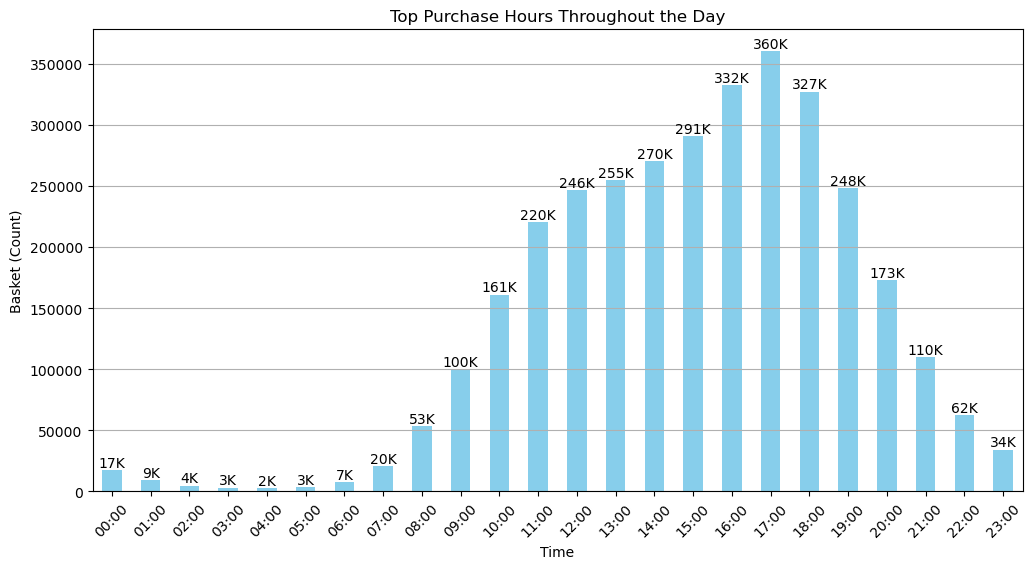

In [41]:
# แปลงค่า time_of_transaction เป็นชั่วโมง (HH)
transactions_combine_by_basket['hour'] = transactions_combine_by_basket['time_of_transaction'].apply(lambda x: int(x // 100))
    
#สร้าง Histogram
plt.figure(figsize=(12, 6))
hour_counts = transactions_combine_by_basket['hour'].value_counts().sort_index()
bars = hour_counts.plot(kind='bar', color='skyblue')
    
#เพิ่ม Label
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval//1000):,}'+"K", ha='center', va='bottom')

plt.title('Top Purchase Hours Throughout the Day')
plt.xlabel('Time')
plt.ylabel('Basket (Count)')
plt.xticks(range(24), [f'{hour:02}:00' for hour in range(24)], rotation=45)
plt.grid(axis='y')
plt.show()

transactions_combine_by_basket = transactions_combine_by_basket.drop(columns=['hour'])
#transactions_combine_by_basket

- ช่วงเวลาที่มีการซื้อขายมากที่สุดคือช่วงตั้งแต่ 10:00 - 20:00 ดังนั้นนี่สามารถ กะเวลาการทำงานภายในร้านเช่น การทำความสะอาดหรือเติมสะต๊อกให้เ่ยงไปช่วงเวลาอื่น 
- การจัดสรรสรรพยากรบุคคลการจ้างพนักงานในช่วงเวลาดังกล่าวมากขึ้น 
- นอกจากนี้ยังสามารถดูพฤตกรรมลูกค้าเพื่อกำหนดเวลาเปิด-ปิดร้าน ในบางช่วงเวลาเพื่อลดต้นทุนในด้านต่าง ๆ 

#### 2) วันที่ลูกค้าซื้อสินค้ามากที่สุดในสัปดาห์ (day):

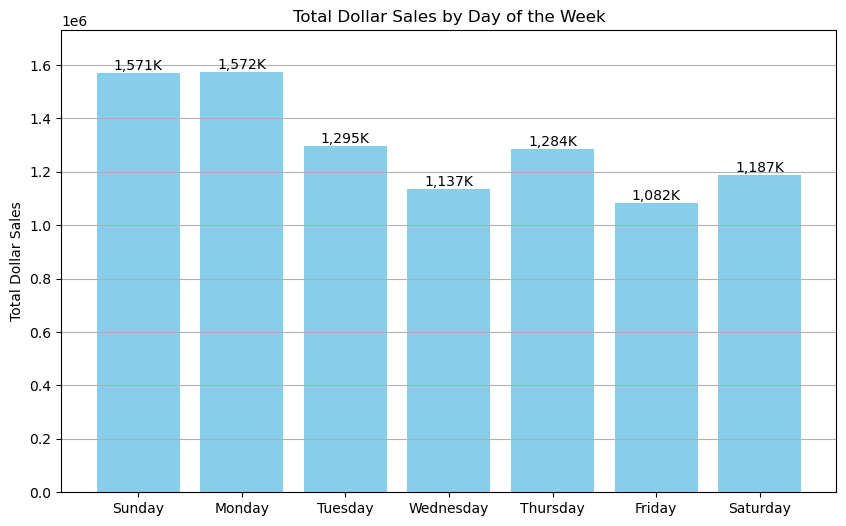

In [42]:
#แบ่งวัน
transactions_combine_by_basket['day_of_week'] = transactions_combine_by_basket['day'] % 7  

# รวมยอดขายตาม day_of_week และแปลง dollar_sales เป็นจำนวนเต็ม
sales_per_day = transactions_combine_by_basket.groupby('day_of_week')['dollar_sales'].sum().apply(lambda x: round(x))
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    
# สร้าง Bar Chart
plt.figure(figsize=(10, 6))
sales_per_day.index = [days[day] for day in sales_per_day.index]  # แปลง day_of_week เป็นชื่อวัน
bars = plt.bar(sales_per_day.index, sales_per_day.values, color='skyblue')
    
# เพิ่ม Label 
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval//1000):,}'+"K", ha='center', va='bottom')

plt.ylim(0, sales_per_day.max()*1.1) 
plt.title('Total Dollar Sales by Day of the Week')
plt.ylabel('Total Dollar Sales')
plt.grid(axis='y')
plt.show()

transactions_combine_by_basket = transactions_combine_by_basket.drop(columns=['day_of_week'])
#transactions_combine_by_basket

- ข้อสังเกตุ คือ ผู้บริโภคมีพฤติกรรมการซื้อสินค้ามากกว่า ในวัน จันทร์และอาทิตย์ อาจจะเพราะเป็นต้นสัปดาห์หรือวันหยุดก่อนขึ้นสัปดาห์ใหม่ก็ตาม 
- อย่างไรก็ดีข้อมูลนี้สามารถำมากำหนด กำหนดการต่างๆในร้านได้เหมือนข้อที่แล้วรวมถึงเรื่องการจัดการพนักงานด้วย 
- หรือการจัดทำโปรโมชั่นเพื่อดึงดูดลูกในค้าในวันอื่นๆก็ได้เช่นกัน  

#### 3) ความสัมพันธ์ของการจัดวางสินค้าละยอดขายแบบอบ่งตามประเภทสินค้า

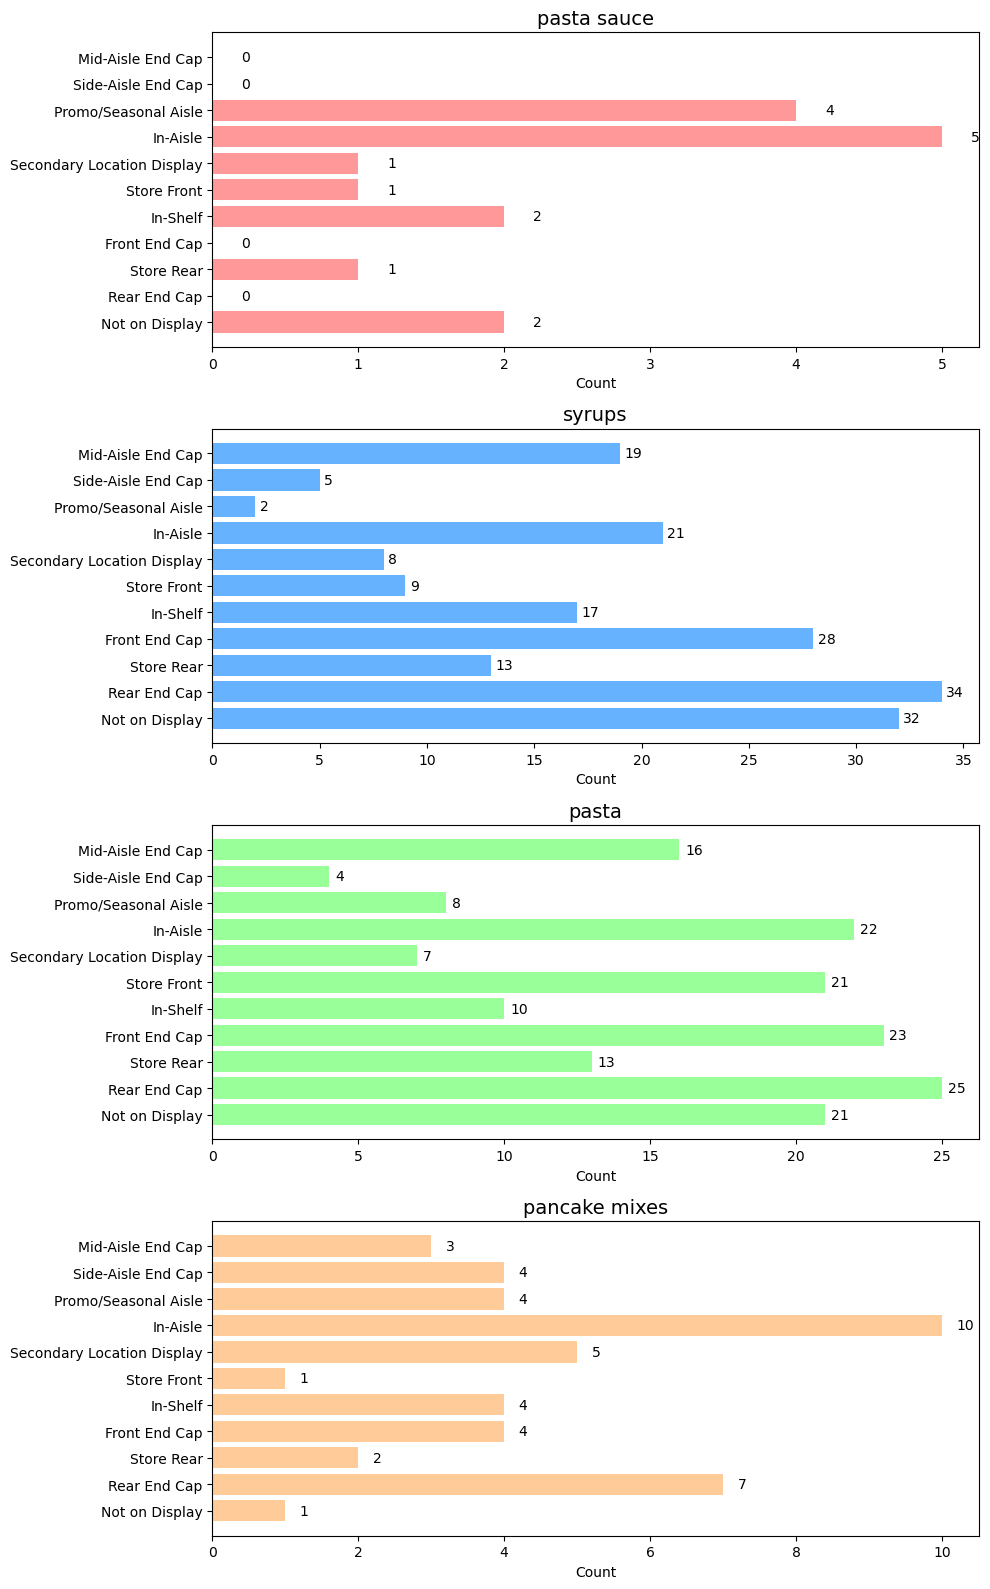

In [43]:
display_types = [
        'Not on Display', 'Rear End Cap', 'Store Rear', 'Front End Cap',
        'In-Shelf', 'Store Front', 'Secondary Location Display', 'In-Aisle',
        'Promo/Seasonal Aisle', 'Side-Aisle End Cap', 'Mid-Aisle End Cap'
    ]


colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']  

fig, axes = plt.subplots(4, 1, figsize=(10, 16))

# ลูปผ่านแต่ละ commodity และทำการพล็อต
for idx, (commodity, color) in enumerate(zip(best_display_by_commodity['commodity'], colors)):
    # เลือก ax ของแต่ละ commodity
    ax = axes[idx]

    # พล็อต bar chart แนวนอน สำหรับแต่ละ commodity
    ax.barh(display_types, best_display_by_commodity.loc[idx, display_types], color=color)

    # เพิ่ม label ที่ปลายแท่ง
    for i, v in enumerate(best_display_by_commodity.loc[idx, display_types]):
        ax.text(v + 0.2, i, f'{v:.0f}', va='center')

    ax.set_title(f'{commodity}', fontsize=14)

    ax.set_xlabel('Count')
    #ax.set_ylabel('Display Types')

plt.tight_layout()
plt.show()

- เป็นกราฟที่แสดงว่าผลิตภัณฑ์ประเภทใดเหมาะที่จะวางสินค้าไว้ส่วนไหนในร้านมากที่สุด
- นี่นำไปสู่การวางแผนการจัดการการวางสินค้าภายในร้านเพื่อยอดขายที่สูงขึ้น 
- การพยายามระบายสินค้าที่ค้างสต๊อกออกไปให้เร็วที่สุด 
- การหาสาเหตุยอดขายที่ไม่ดีของสินค้าบางชนิดนี่อาจไม่เกี่ยวกับตัวสินค้าแต่เป็นการจัดวางก็ได้ แน่นอนว่านี่ยังไม่รวมการแบ่งจากพื้นที่ที่ร้านค้าตั้งอยู่อีกเพราะพฤติกรรมของบางพื้นที่อาจไม่เหมือนกัน แต่อย่างไรก็ดี 
- แผนภูมินี้สามารถบอกได้ว่าลูกค้าส่วนใหญ้มันจะซื้อสินคาประเภทในเมื่อมันถูกจัดวางอย่างไร

#### 4) ความสัมพันธ์ของการจัดวางสินค้าละยอดขายแบบอบ่งตามรหัสสินค้า

In [44]:
# หาค่า display_desc ที่มี Avg_units มากที่สุดสำหรับแต่ละ upc
best_display_df = df_upc_display.loc[df_upc_display.groupby('upc')['Avg_units'].idxmax()].copy()

# กำหนดประเภทของ display_desc ที่ต้องการเก็บข้อมูล
display_types = [
        'Not on Display', 'Rear End Cap', 'Store Rear', 'Front End Cap',
        'In-Shelf', 'Store Front', 'Secondary Location Display', 'In-Aisle',
        'Promo/Seasonal Aisle', 'Side-Aisle End Cap', 'Mid-Aisle End Cap'
        ]

# สร้างตารางใหม่โดยใช้ upc เป็นคีย์หลัก
best_display_by_upc = pd.DataFrame(best_display_df['upc'].unique(), columns=['upc'])

# เพิ่มคอลัมน์สำหรับแต่ละ display_desc และเก็บค่าจำนวนนับ
for display in display_types:
    best_display_by_upc[display] = (best_display_df['display_desc'] == display).groupby(best_display_df['upc']).sum().values

best_display_by_upc

,upc,Not on Display,Rear End Cap,Store Rear,Front End Cap,In-Shelf,Store Front,Secondary Location Display,In-Aisle,Promo/Seasonal Aisle,Side-Aisle End Cap,Mid-Aisle End Cap
0,601011292,0,0,0,0,1,0,0,0,0,0,0
1,601011293,0,1,0,0,0,0,0,0,0,0,0
2,601011294,1,0,0,0,0,0,0,0,0,0,0
3,601011295,0,0,0,0,0,0,0,1,0,0,0
4,601011296,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
414,9999985215,0,1,0,0,0,0,0,0,0,0,0
415,9999985217,0,0,1,0,0,0,0,0,0,0,0
416,9999985260,0,0,1,0,0,0,0,0,0,0,0
417,9999985261,0,0,0,0,0,1,0,0,0,0,0


In [56]:
# หาค่า display_desc ที่มี Avg_units มากที่สุดสำหรับแต่ละ upc
best_display_df = df_upc_display.loc[df_upc_display.groupby('upc')['Avg_units'].idxmax()].copy()

# กำหนดประเภทของ display_desc ที่ต้องการเก็บข้อมูล
display_types = [
        'Not on Display', 'Rear End Cap', 'Store Rear', 'Front End Cap',
        'In-Shelf', 'Store Front', 'Secondary Location Display', 'In-Aisle',
        'Promo/Seasonal Aisle', 'Side-Aisle End Cap', 'Mid-Aisle End Cap'
        ]

# สร้างตารางใหม่โดยใช้ upc เป็นคีย์หลัก
best_display_by_upc = pd.DataFrame(best_display_df['upc'].unique(), columns=['upc'])

# เพิ่มคอลัมน์ 'best_display' ซึ่งเป็น display_desc ที่มีค่านับมากที่สุดสำหรับแต่ละ upc
best_display_by_upc['best_display'] = best_display_df.groupby('upc')['display_desc'].agg(lambda x: x.value_counts().idxmax()).values
best_display_by_upc['upc'] = best_display_by_upc['upc'].astype(str)
#best_display_by_upc


# ฟังก์ชันสำหรับคืนค่า best_display จาก upc
def find_best_display(upc, df):
    result = df[df['upc'] == upc]
    if not result.empty:
        return result['best_display'].values[0]
    else:
        return "UPC not found"

       

upc_input = input("Enter UPC: ")
best_display_result = find_best_display(upc_input, best_display_by_upc)
best_display_result

Enter UPC: 601011292


'In-Shelf'

- ถัดจากหัวข้อทีแล้วในส่วนนี้สามารถดูได้เลยว่าถ้าเป็นสินค้าชนิดใดๆควรวางไว้ตรงไหน เพื่อที่จะสามารถทำยอดขายได้สูงที่สุด

#### 5) ร้านค้าที่มียอดขายสูงสุดและต่ำสุด 10 อันดับ

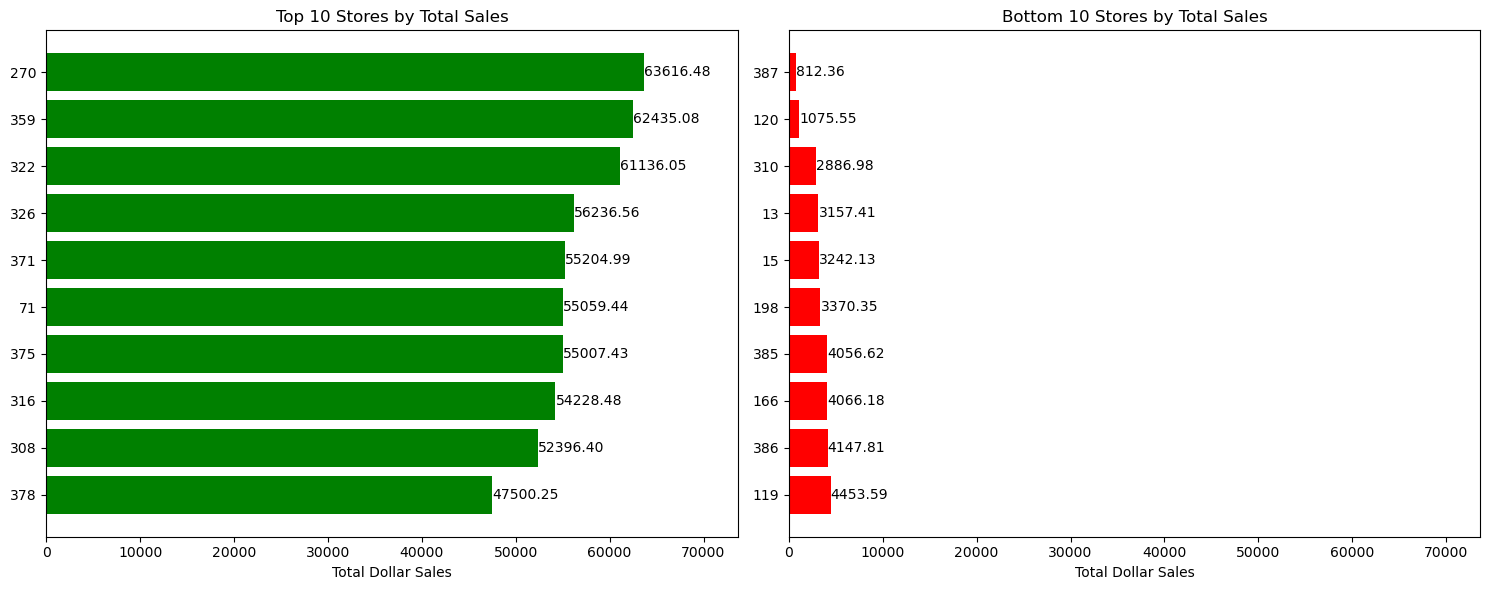

In [46]:
totel_store['store'] = totel_store['store'].astype(str)

# จัดเรียงข้อมูลตามยอดขาย totel_dollar_sales
totel_store_sorted = totel_store.sort_values(by='totel_dollar_sales')

# เลือก 10 ร้านที่มียอดขายมากที่สุด และน้อยที่สุด
top_10_sales = totel_store_sorted.tail(10).sort_values(by='totel_dollar_sales', ascending=False)  
bottom_10_sales = totel_store_sorted.head(10).sort_values(by='totel_dollar_sales')  

# กำหนดขอบเขตสเกลเดียวกันสำหรับทั้งสองกราฟ
max_value = max(top_10_sales['totel_dollar_sales'].max(), bottom_10_sales['totel_dollar_sales'].max())

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# พล็อตกราฟสำหรับร้านค้าที่มียอดขายมากที่สุด 10 อันดับ
axes[0].barh(top_10_sales['store'], top_10_sales['totel_dollar_sales'], color='green')
axes[0].set_title('Top 10 Stores by Total Sales')
axes[0].set_xlabel('Total Dollar Sales')
axes[0].invert_yaxis()  
axes[0].set_xlim(0, max_value+10000) 

# เพิ่ม Label
for i, v in enumerate(top_10_sales['totel_dollar_sales']):
    axes[0].text(v + 0.2, i, f'{v:.2f}', va='center')

# พล็อตกราฟสำหรับร้านค้าที่มียอดขายน้อยที่สุด 10 อันดับ
axes[1].barh(bottom_10_sales['store'], bottom_10_sales['totel_dollar_sales'], color='red')
axes[1].set_title('Bottom 10 Stores by Total Sales')
axes[1].set_xlabel('Total Dollar Sales')
axes[1].invert_yaxis()  
axes[1].set_xlim(0, max_value+10000) 

# เพิ่ม Label
for i, v in enumerate(bottom_10_sales['totel_dollar_sales']):
    axes[1].text(v + 0.2, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()

- เป็นการจัดอันดับร้านค้าที่สามารถทำผลงานได้ดีมี่สุดและน้อยที่สุด ซึ่งสามารถดูผลประกอบการ
- บ่งบอกได้ถึงความสามารถในการทำรายได้ในระยะยาวของร้านต่างๆได้ 
- แน่นอนว่าสามารถใช้ัดสินใจกำหนดทิศทางหรือการปรับปรุงพัฒนาร้านเพิ่มเติมได้อีกด้วย 
- การกระจายตัวของยอดขายช่วงต่ำสุดสูงสุดของมูลค่าที่แต่ลร้านสามารถทำได้

#### 6) สินค้าที่มียอดขายสูงที่สุด

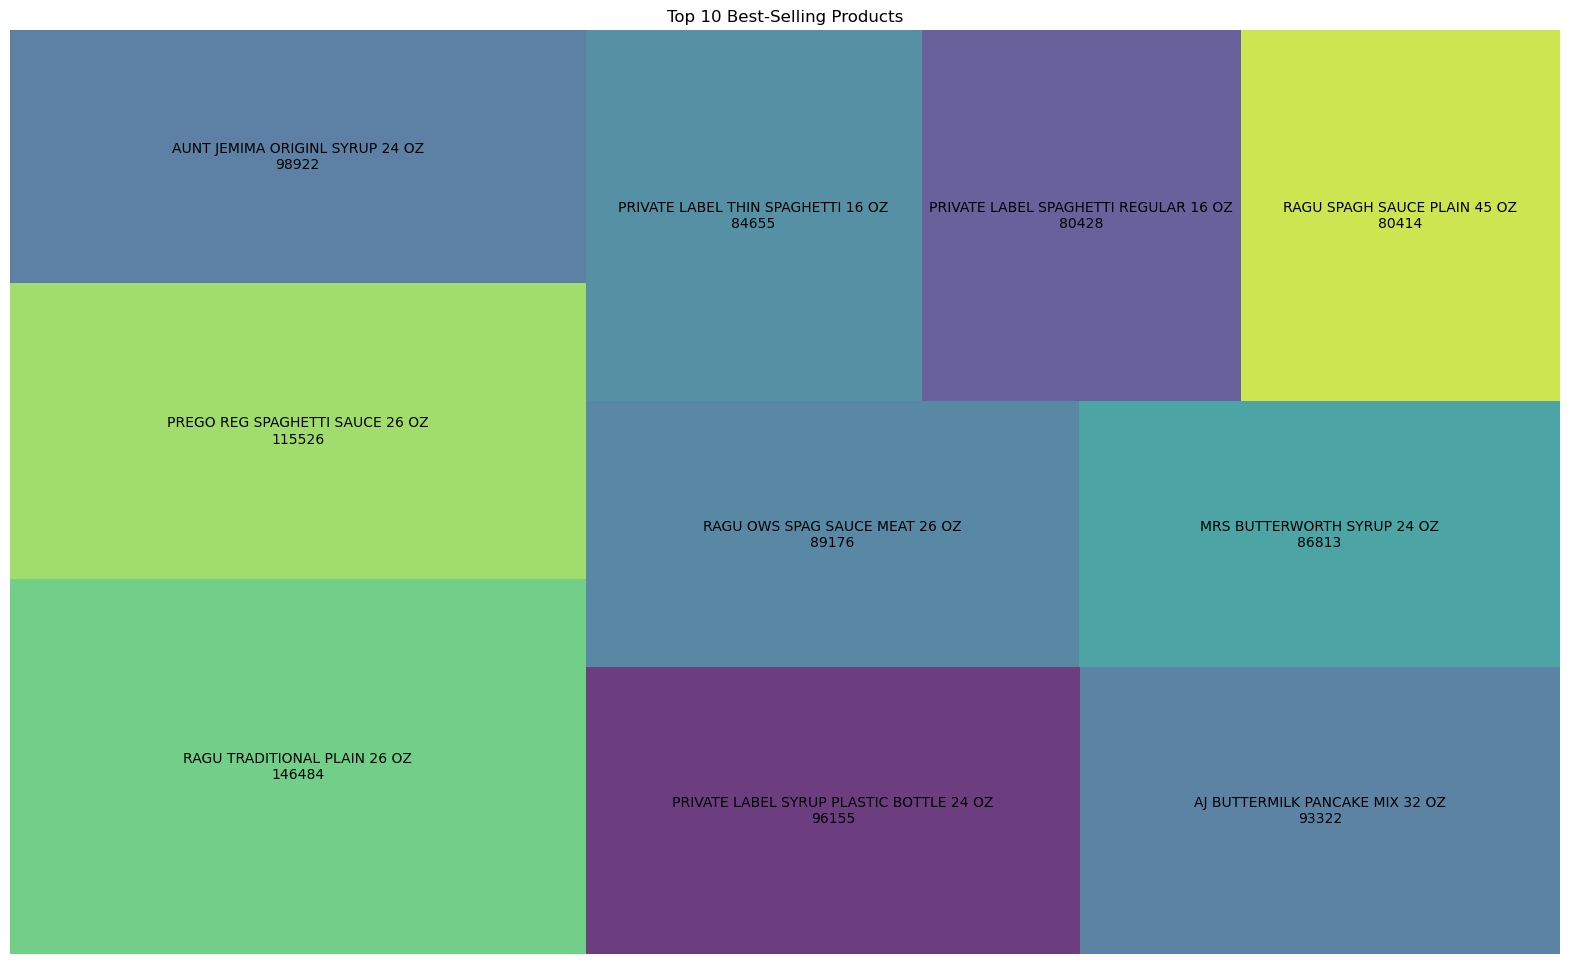

In [47]:
most_sales_product = totel_product_sales[['product_description', 'product_size', 'totel_sales']].sort_values(by='totel_sales', ascending=False).head(10)

labels = most_sales_product['product_description'] + " " + most_sales_product['product_size'] + "\n" + most_sales_product['totel_sales'].astype(int).astype(str)

plt.figure(figsize=(20, 12))
squarify.plot(sizes=most_sales_product['totel_sales'], label=labels, alpha=.8)

plt.title('Top 10 Best-Selling Products')
plt.axis('off')
plt.show()

- สามารถเข้าใจได้ว่าสินค้าใดบ้างที่สามารถสร้างมูลค่าให้ได้มากที่สุด 
- แนวโน้มการซื้อของลูกค้า หรือสามารถเลือกสินค้าที่ควรจะโปรโมทได้ 
- บอกพฤติกรรมการบริโภคของลูกค้าได้อีกด้วย อ
- ย่างสินค้าที่มียอดขายสูงที่สุดก็ไม่ใช่สินค้าเดียวกันกับสินค้าที่มียอดจำหน่ายสูงที่สุดด้วยปัจจัยด้วยราคา นี่อาจจะเป็นหนึ่งในตัวกำหนดกลยุทธ์ในการทำโปรโมชั่นหรือการขายสินค้าในอนาคตได้

##### 7) สินค้าที่มีจำนวนการจำหน่ายสูงที่สุด 

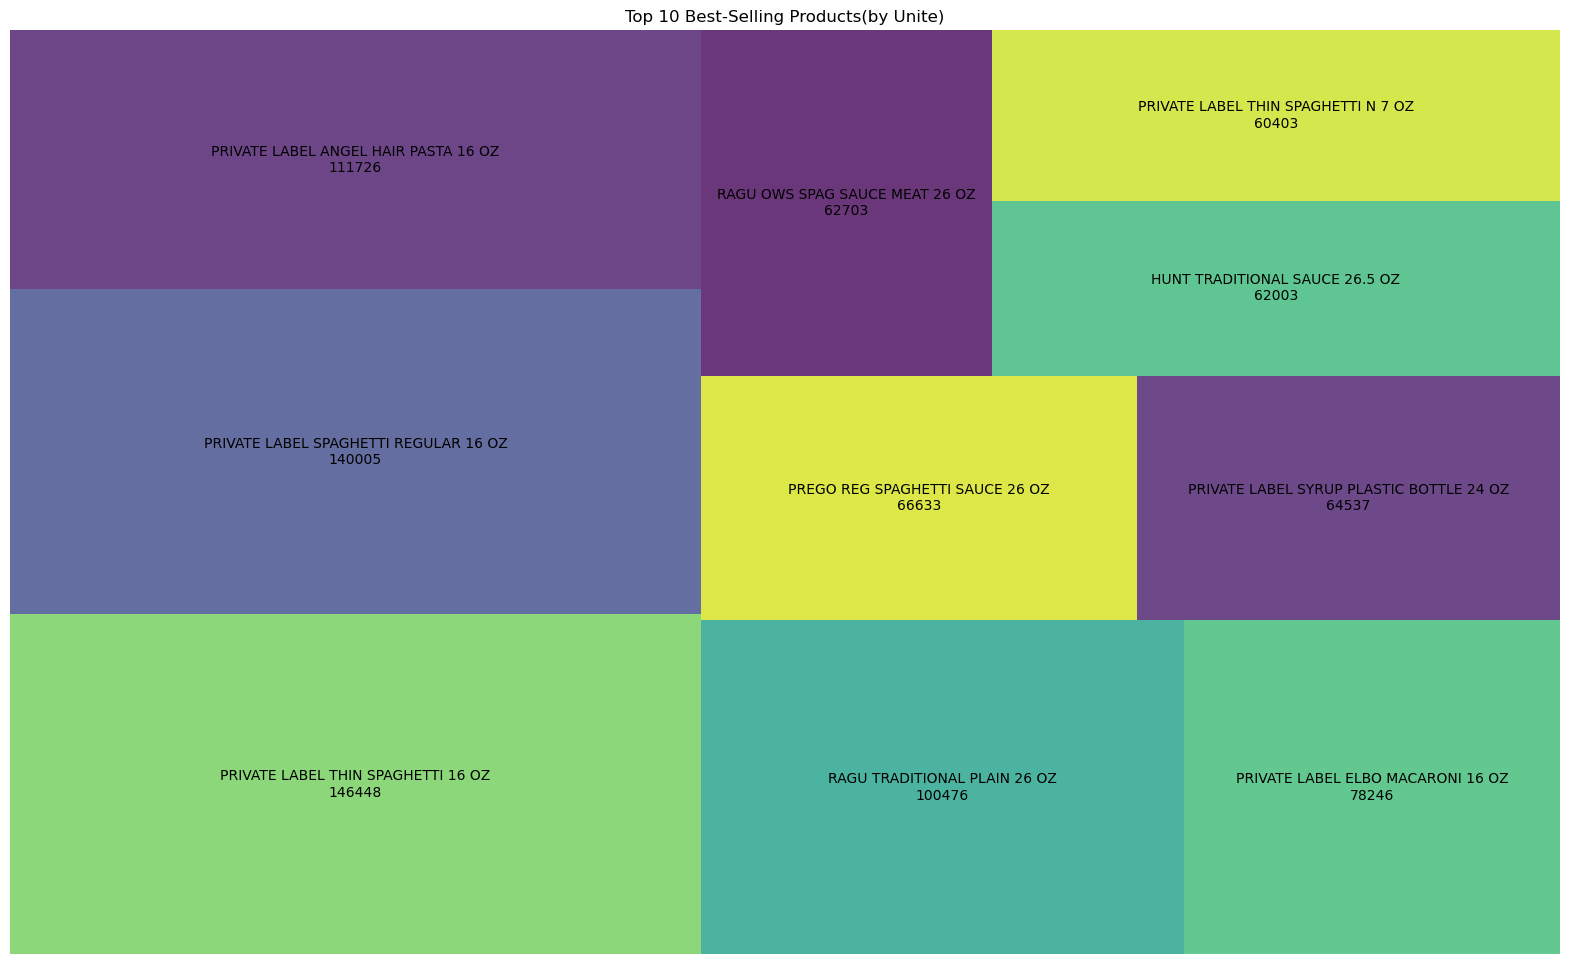

In [48]:
most_sales_product = totel_product_sales[['product_description', 'product_size', 'totel_unite']].sort_values(by='totel_unite', ascending=False).head(10)
labels = most_sales_product['product_description'] + " " + most_sales_product['product_size'] + "\n" + most_sales_product['totel_unite'].astype(int).astype(str)
plt.figure(figsize=(20, 12))
squarify.plot(sizes=most_sales_product['totel_unite'], label=labels, alpha=.8)
plt.title('Top 10 Best-Selling Products(by Unite)')
plt.axis('off')
plt.show()

- หลักๆสามารถทำได้เหมือนข้อที่แล้วเลน แต่สามารถจัดการเกี่ยวกับการสต๊อคสินค้าเพิ่มเติมได้ 
- หรือการางแผนการจัดซื้อสินค้า เช่น การซื้อสินค้ายอดนิยมมาในปริมาณมากๆเพื่อการลดต้นทุนแล้วค่อยนำมาทยอยขาย 
- นี้ังสามารถบอกถึงสินค้าที่ไ้รับความนิยมหรือสามารถดูได้ว่านี่เป็นสินค้าที่สัมพันธ์กับการใช้งานทุกไปหรือเกี่ยวเนื่องกับกลุ่มคน เช่น ของใช้ในชีวิตประจำวัน 

#### 8) แบรนด์ที่มียอดขายสูงที่สุด

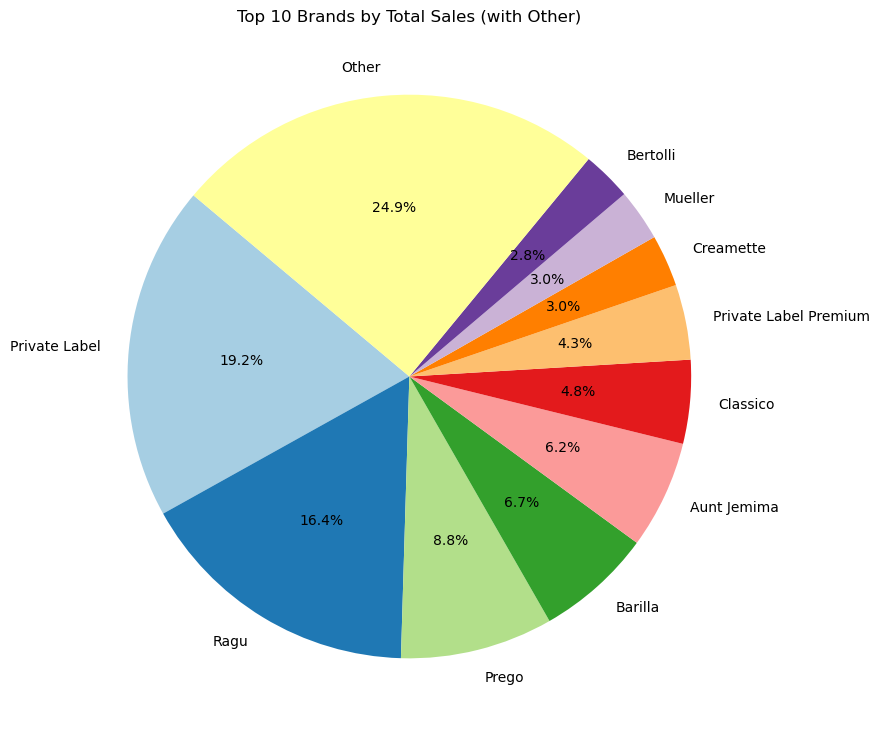

In [49]:
# รวมยอดขายตามแบรนด์ (brand)
brand_sales = totel_product_sales.groupby('brand')['totel_sales'].sum().reset_index().sort_values(by='totel_sales', ascending=False)
top_10_brands = brand_sales.head(10)
other_sales = brand_sales['totel_sales'].iloc[10:].sum()

# เพิ่มแถวสำหรับ 'Other' ที่รวมยอดขายของแบรนด์ที่เหลือโดยใช้ pd.concat
other_row = pd.DataFrame([{'brand': 'Other', 'totel_sales': other_sales}])
top_10_brands = pd.concat([top_10_brands, other_row], ignore_index=True)

plt.figure(figsize=(8, 9))
plt.pie(top_10_brands['totel_sales'], labels=top_10_brands['brand'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Brands by Total Sales (with Other)')
plt.axis('equal')
plt.show()

- สามารถบอกได้ถึงแบรนด์ที่มีส่วนแบ่งทางการตลาดในร้านมากที่สุด หมายความว่าเป็นพาร์ทเนอร์ทางการค้าที่ส่งผลกระทบหลักๆต่อการดำเนินงานภายใน 
- สามารถบอกได้ถึงสภาพการแข่งขันของแบรนด์สินค้าต่างๆในตลาด 
- สามารถนำไปกำหนดโปรโมชั่นหรือการทำสัญญาในแง่ต่างๆได้

#### 9) แบรนด์ที่มีจำนวนยอดขายสินค้าสูงที่สุด

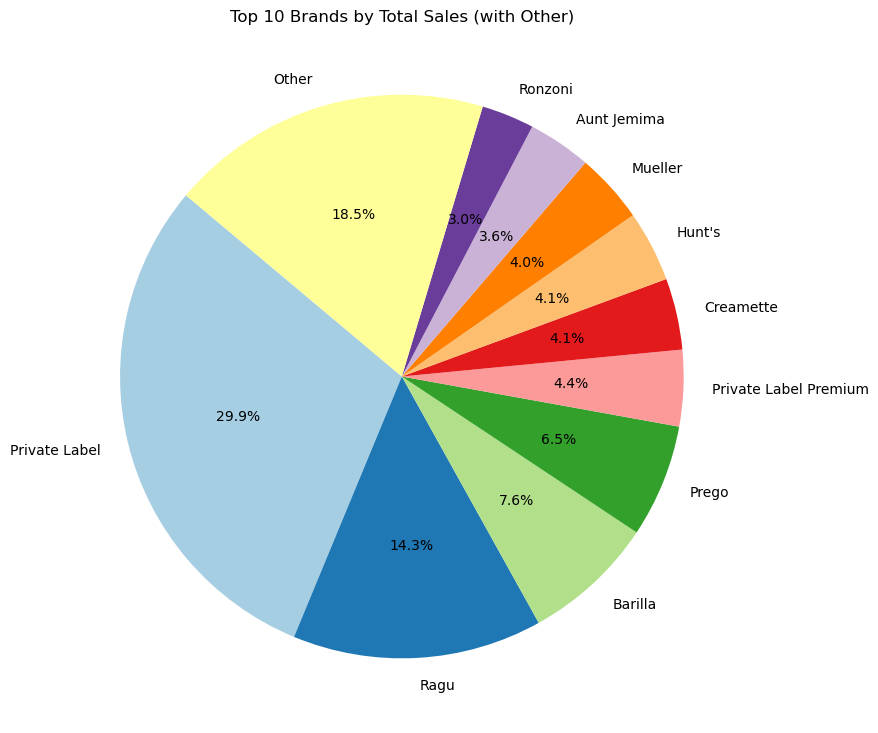

In [50]:
brand_sales = totel_product_sales.groupby('brand')['totel_unite'].sum().reset_index().sort_values(by='totel_unite', ascending=False)
top_10_brands = brand_sales.head(10)
other_sales = brand_sales['totel_unite'].iloc[10:].sum()

# เพิ่มแถวสำหรับ 'Other' ที่รวมยอดขายของแบรนด์ที่เหลือโดยใช้ pd.concat
other_row = pd.DataFrame([{'brand': 'Other', 'totel_unite': other_sales}])
top_10_brands = pd.concat([top_10_brands, other_row], ignore_index=True)

plt.figure(figsize=(8, 9))
plt.pie(top_10_brands['totel_unite'], labels=top_10_brands['brand'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Brands by Total Sales (with Other)')
plt.axis('equal')
plt.show()

- สามารถบอกแยรนด์ยอดนิยมของร้านค้าได้ เพื่อกำหนดกลยุทธ์หรือการจัดการระบบหลังบ้านในภายหลัง
- พลฤติกรรมการบริโภคสินค้า จะเห็นว่าแม้ Private Label จะเป็นแบรนด์ที่สามารถทำยอดขายและจำนวนสินค้าที่สูงที่สุด แต่เปอร์เซ็นของจำนวนสินค้าที่ขายเยอะกว่ายอด นี่อาจจะอนุมาณได้ว่า เป็นแบรนด์ที่ขายสินค้าในราคาที่ไม่ได้สูงมากแต่เน้นขอายในปริมาณมาก เช่นเดียวกันมันสามารถสะท้อนพฤติกรรมของผู้บริโภคได้ด้วยว่ามีความสนใจในแมสโปรดักที่มีราคาถูกมากกว่า 
- ความต้องการของตลาด

#### 10) สัดส่วนประเภทสินค้ายอดนิยม 

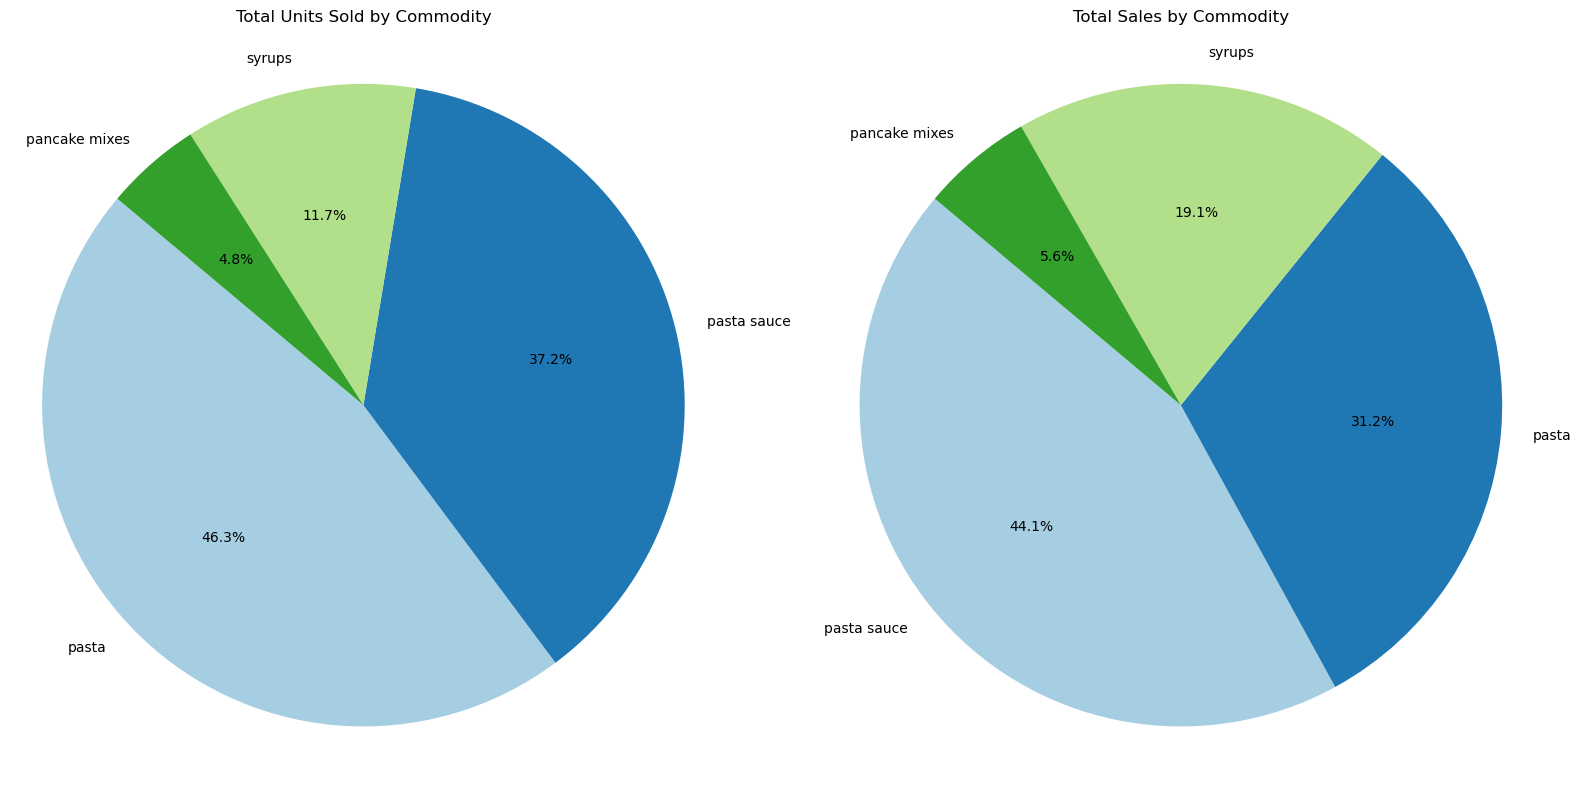

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# จำนวนหน่วยขายตามประเภทสินค้า 
commodity_units = totel_product_sales.groupby('commodity')['totel_unite'].sum().reset_index().sort_values(by='totel_unite', ascending=False)
axes[0].pie(commodity_units['totel_unite'], labels=commodity_units['commodity'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[0].set_title('Total Units Sold by Commodity')
axes[0].axis('equal')  # ให้กราฟเป็นวงกลม

# ยอดขายรวมตามประเภทสินค้า
commodity_sales = totel_product_sales.groupby('commodity')['totel_sales'].sum().reset_index().sort_values(by='totel_sales', ascending=False)
axes[1].pie(commodity_sales['totel_sales'], labels=commodity_sales['commodity'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[1].set_title('Total Sales by Commodity')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

- บ่งบอกถึงสินค้าประเภทที่สามารภสร้างยอดขายให้กับร้านค้าได้มากที่สุด แปลว่าเป็นกลุ่มสินค้าที่ส่งผลต่อร้านมากที่สุด
- บ่งบอกถึงสินค้าประเภทที่สามารภจำหน่ายได้มากที่สุด 
- สามารถดูความนิยมหรือวางแผนสต๊อกสินค้า
- สินค้าที่มีปริมาณการซื้อซ้ำบ่อย ทั้งในแง่ความนิยม ความจำเป็น หรือเป็นสินค้าที่ใช้แล้วหมดไปได้ง่าย
- ความหลากหลายของสินค้าที่สามารถจำหน่ายได้ในร้าน เช่น pancake mixes ยังมีพื้นที่ให้เติบโตหรือส่งเสิมการขายเพิ่มเติมได้อีก

#### 11) แบรนด์ที่มีส่วนแบ่งการตลาดมากที่สุดเมื่อนับเฉพาะแบรนด์ที่มีขายในร้าน

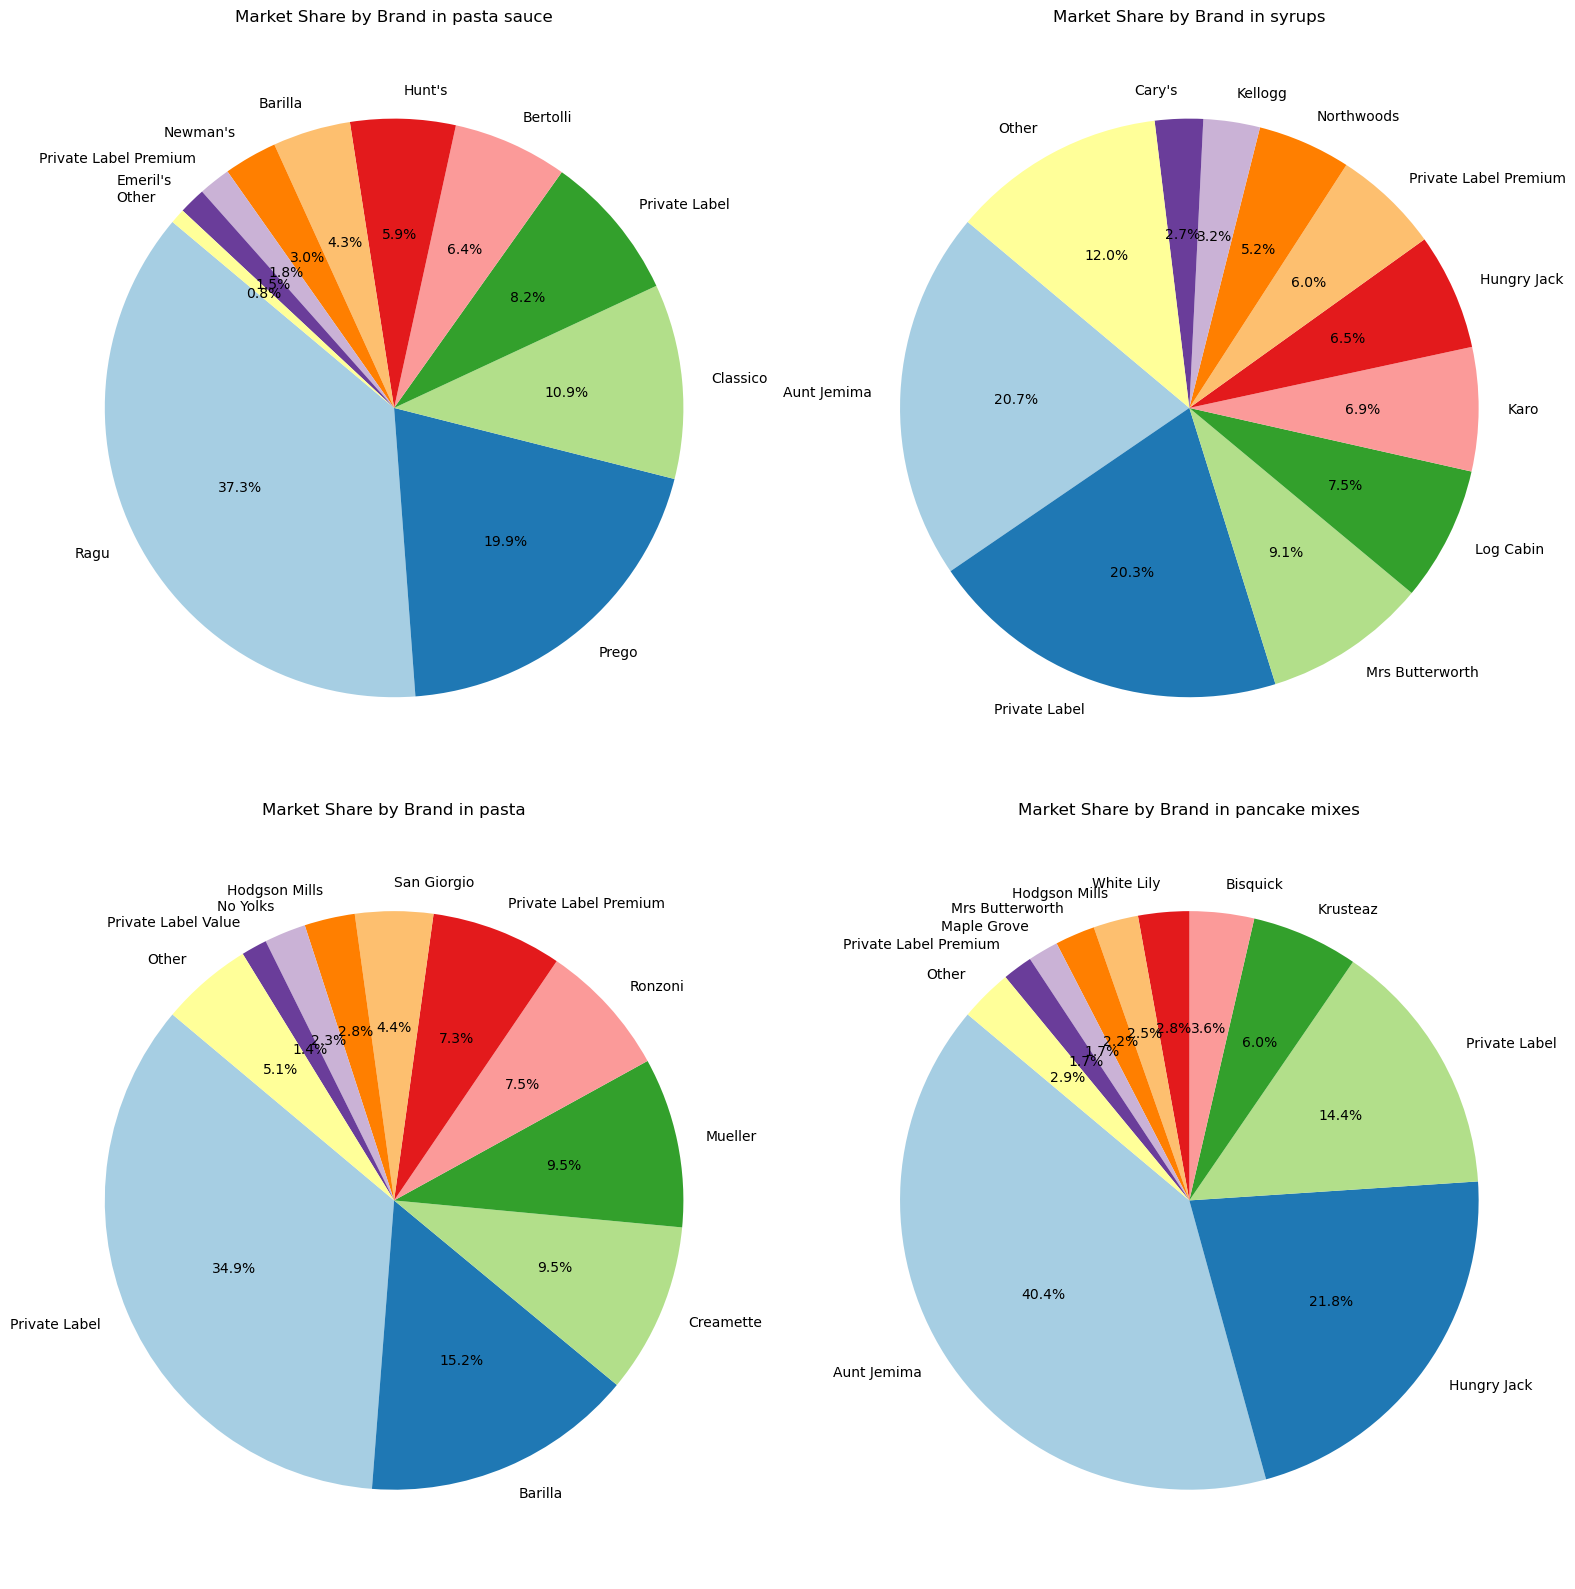

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
colors = plt.cm.Paired.colors

# วนลูปผ่านประเภทสินค้าทั้งหมด
commodities = totel_product_sales['commodity'].unique()
for i, commodity in enumerate(commodities):
    # เลือกข้อมูลเฉพาะ commodity นั้น ๆ
    data = totel_product_sales[totel_product_sales['commodity'] == commodity]

    # รวมยอดขายตามแบรนด์
    brand_sales = data.groupby('brand')['totel_sales'].sum().reset_index().sort_values(by='totel_sales', ascending=False)
    top_10_brands = brand_sales.head(10)
    other_sales = brand_sales['totel_sales'].iloc[10:].sum()
    other_row = pd.DataFrame([{'brand': 'Other', 'totel_sales': other_sales}])
    top_10_brands = pd.concat([top_10_brands, other_row], ignore_index=True)

    row = i // 2
    col = i % 2
    axes[row, col].pie(top_10_brands['totel_sales'], labels=top_10_brands['brand'], autopct='%1.1f%%', startangle=140, colors=colors)
    axes[row, col].set_title(f'Market Share by Brand in {commodity}')
    axes[row, col].axis('equal')

plt.tight_layout()
plt.show()

- สามารถบอกส่วนแบ่งการตลาดของแบรนด์ต่างๆในสินค้าแต่ละประเภท 
- ความนิยมของแบรนด์ต่างๆ
- การกระจายของผลิตภัณฑ์ในแต่ละแบรนด์ 
- ความถนันในการผลิตสินค้าและคุณภาพสินค้าของสินค้าประเภทต่างๆที่แต่ละแบรนด์สามารถทำได้
- การจัดโปรโมชั่น เช่นสามารถจัดเซ็ตสินค้าที่มีความยอดนิยมด้วยราคาพิเศษ

#### 12) แบรนด์ที่มีจำนวนชนิดสินค้ามากที่สุด

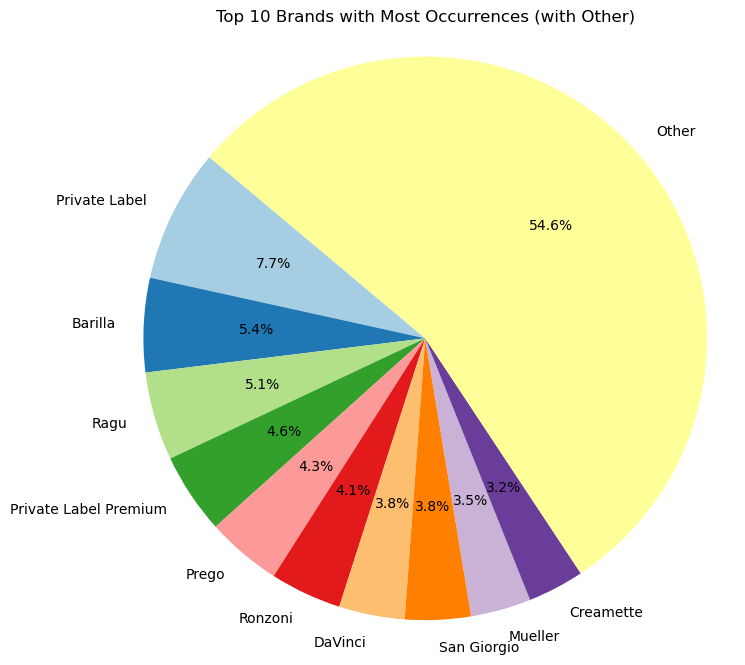

In [53]:
brand_counts = product_lookup['brand'].value_counts().reset_index()
brand_counts.columns = ['brand', 'count']

top_10_brands = brand_counts.head(10)

other_count = brand_counts['count'].iloc[10:].sum()

other_row = pd.DataFrame([{'brand': 'Other', 'count': other_count}])
top_10_brands = pd.concat([top_10_brands, other_row], ignore_index=True)

plt.figure(figsize=(8, 8))
plt.pie(top_10_brands['count'], labels=top_10_brands['brand'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Brands with Most Occurrences (with Other)')
plt.axis('equal')
plt.show()

- ความหลากหลายของสินค้าในร้าน เช่น ถ้ามีสินค้าจากแบรนด์ใดแบรนด์หนึ่งเยอะเกินไปอาจจะทำให้ยอดขายลดลง
- ความครอบคลุมของสินค้าที่มีขายในร้าน
- พาร์ทเนอร์ที่สำคัญของร้านิ

#### 13) แบรนด์ที่ให้คูปองมากที่สุด 

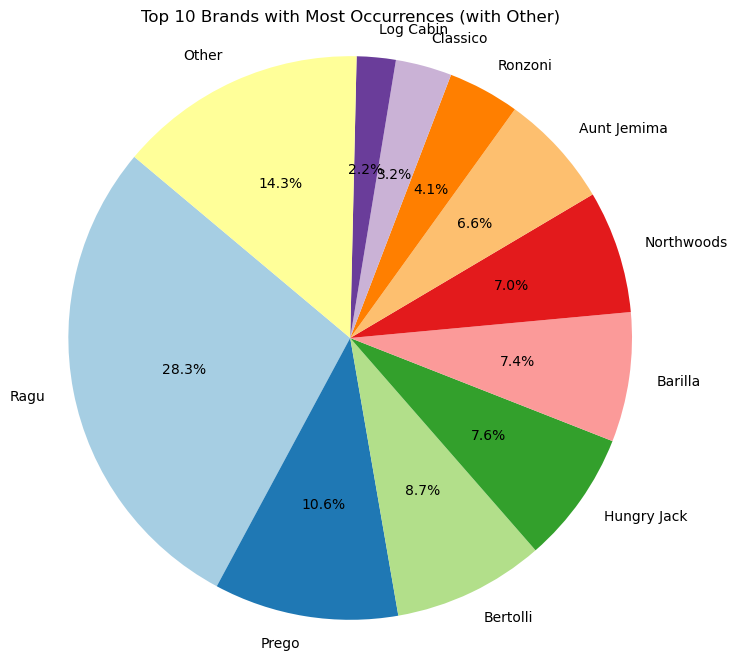

In [54]:
brand_counts = transactions_coupon['brand'].value_counts().reset_index()
brand_counts.columns = ['brand', 'count']

top_10_brands = brand_counts.head(10)

other_count = brand_counts['count'].iloc[10:].sum()
other_row = pd.DataFrame([{'brand': 'Other', 'count': other_count}])
top_10_brands = pd.concat([top_10_brands, other_row], ignore_index=True)

plt.figure(figsize=(8, 8))
plt.pie(top_10_brands['count'], labels=top_10_brands['brand'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Brands with Most Occurrences (with Other)')
plt.axis('equal')
plt.show()

- แบรนด์ที่ใช้คูปองเป็นกลยุทธ์ในการเพิ่มยอดขาย
- ความถี่หรือจำนวนการให้คูปองของแบรนด์ต่างๆ
- ความสำคัญของคูปองต่อยอดขายและความนิยมของแบรนด์ เช่น แบรนด์ที่ให้คูปองเยอะที่สุดแต่ไม่ได้รับความนิยมมากที่สุด ในขณะเดียวกันแบรนด์ที่ได้รับความนิยมสูงที่สุดกลับไม่มีการแจกคูปอในปริมาณที่ยอะ
- สามารถเพิ่มการตกลงกับแบรนด์ต่างๆ เช่น การแจกคูปองเพิ่ม เพื่อเพิ่มยอดขายทั้งสองฝ่าย
- ปรับปรุงการแจกคูปองในแต่ละแบรนด์

#### 14) ความสัมพันธ์ระหว่างการใช้คูปองและยอดขายของร้านค้า

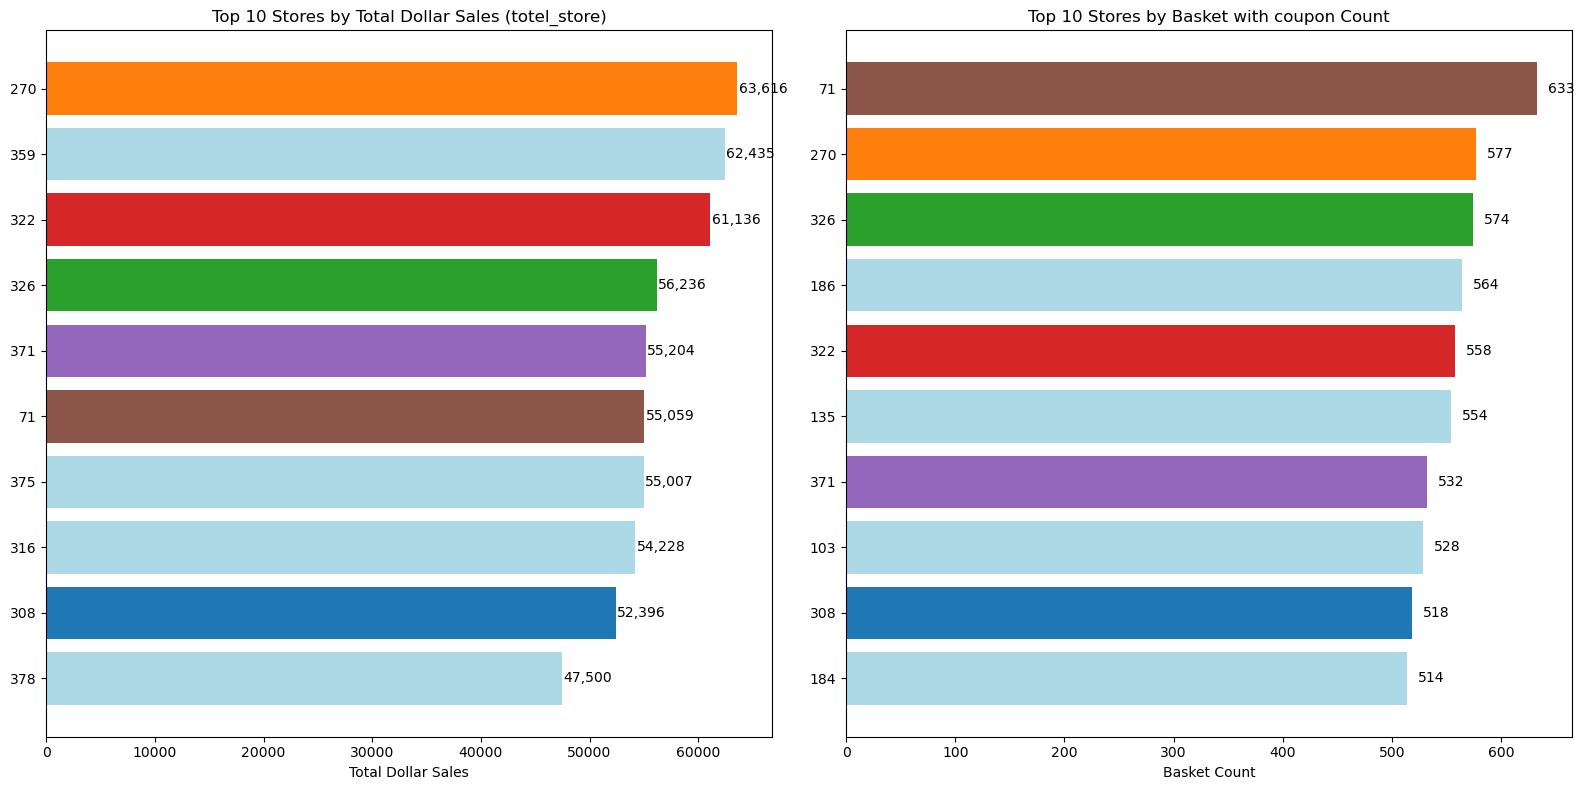

In [81]:
store_coupon['store'] = store_coupon['store'].astype(str)
totel_store['store'] = totel_store['store'].astype(str)

df_sorted_sales = totel_store.sort_values(by='totel_dollar_sales', ascending=False)
df_sorted_basket = store_coupon.sort_values(by='basket_count', ascending=False)


top_10_sales = df_sorted_sales.head(10)
top_10_basket = df_sorted_basket.head(10)

# ค้นหาร้านค้าที่ซ้ำกันในทั้งสองกราฟ
common_stores = set(top_10_sales['store']).intersection(set(top_10_basket['store']))

# ดึง colormap ออกมา และกำหนดสีสำหรับคู่ที่ซ้ำกัน
unique_colors = plt.colormaps['tab10']  
store_color_map = {}  # เก็บสีของร้านที่ซ้ำกัน
for i, store in enumerate(common_stores):
    store_color_map[store] = unique_colors(i % 10)  


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# จัดการสี: ร้านที่ปรากฏในทั้งสองกราฟจะใช้สีเดียวกัน ส่วนร้านที่ไม่มีคู่จะใช้สีฟ้าอ่อน (lightblue)
color_map_sales = [store_color_map.get(store, 'lightblue') for store in top_10_sales['store']]
color_map_basket = [store_color_map.get(store, 'lightblue') for store in top_10_basket['store']]

# พล็อตกราฟสำหรับร้านค้าที่มียอดขายมากที่สุด 10 อันดับ (totel_dollar_sales)
axes[0].barh(top_10_sales['store'], top_10_sales['totel_dollar_sales'], color=color_map_sales)
axes[0].set_title('Top 10 Stores by Total Dollar Sales (totel_store)')
axes[0].set_xlabel('Total Dollar Sales')
axes[0].invert_yaxis()

# เพิ่ม Label
for i, v in enumerate(top_10_sales['totel_dollar_sales']):
    axes[0].text(v + 100, i, f'{int(v):,}', va='center')

# พล็อตกราฟสำหรับร้านค้าที่มี basket_count มากที่สุด 10 อันดับ 
axes[1].barh(top_10_basket['store'], top_10_basket['basket_count'], color=color_map_basket)
axes[1].set_title('Top 10 Stores by Basket with coupon Count')
axes[1].set_xlabel('Basket Count')
axes[1].invert_yaxis()  

# เพิ่ม Label
for i, v in enumerate(top_10_basket['basket_count']):
    axes[1].text(v + 10, i, f'{int(v):,}', va='center')

plt.tight_layout()
plt.show()

- ผลกระทบของคูปองต่อยอดขาย จะเห็นว่าในจำนวนร้านที่มีการแจกคูปองเยอะที่สุดีหลายร้านที่สามารถทำยอดขายได้สูงที่สุดด้วยเช่นเดียวกน
- ความสำเร็จและประสิทธิภาพการใช้คูปอง เป็นทางบวกคือสามารถใช้แล้วเพิ่มยอดขายได้
- สามารถนำไปปรับใช้กับร้านค้าอื่นๆ เช่น การเพิ่มคูปองในร้านต่างๆ
- การวางแผนทิศทาง เช่น คูปองใช้ได้ผล อสจจะเพิ่มงบไปลงให้การใช้คูปอง เพื่อเพิ่มยอดขาย
- สามารถนำไปเจรจากับพาร์ทเนอร์เพื่อผลประโยชน์ของทั้ง 2 ฝ่ายได้

#### 15) แสดงการจัดอันดับความนิยมของขนาดผลิตภัณธ์โดยแยกตามประเภทของสินค้า

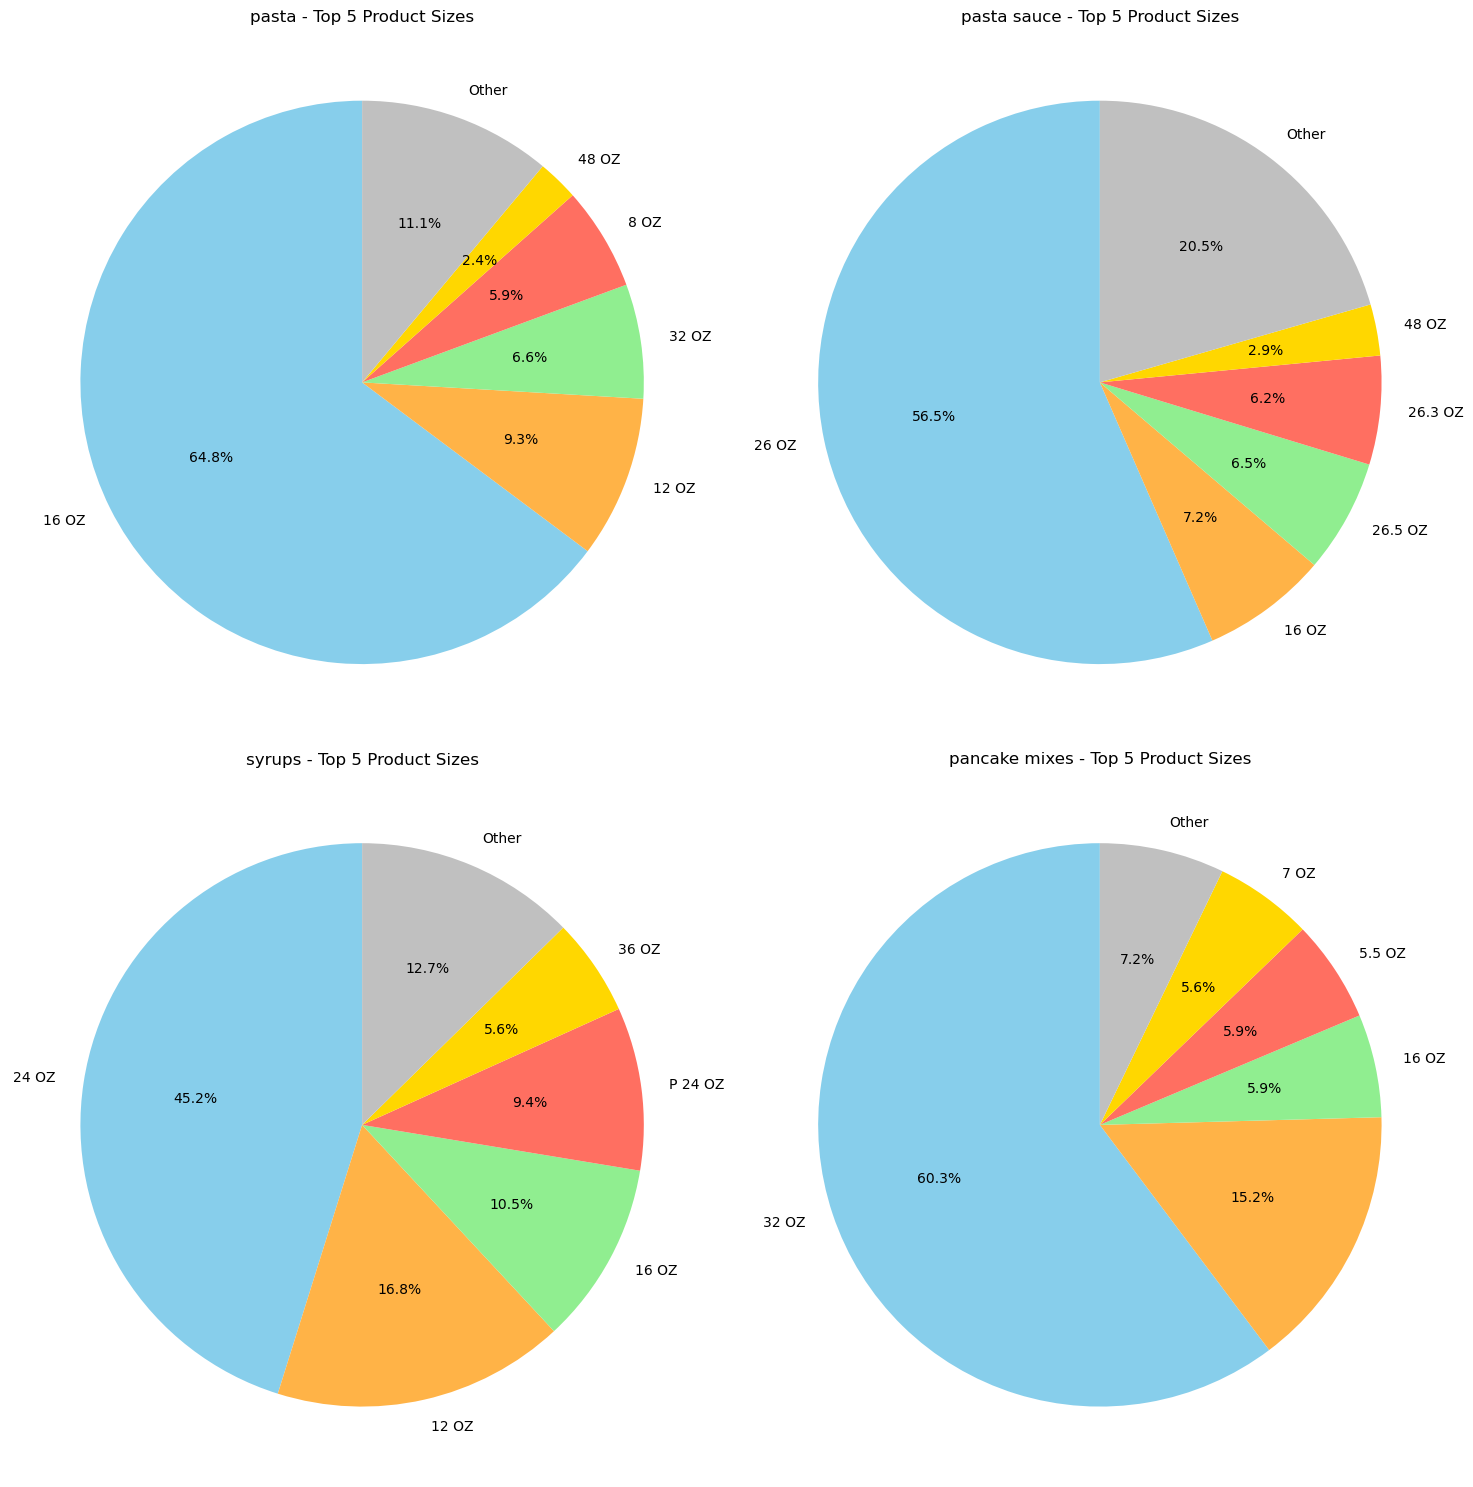

In [70]:
# จัดกลุ่มข้อมูลตาม commodity และ product_size และรวมค่า totel_unite
df = totel_product_sales_by_commodity_size
grouped_df = df.groupby(['commodity', 'product_size']).agg({
    'totel_sales': 'sum',
    'totel_unite': 'sum'
}).reset_index()

grouped_df = grouped_df.sort_values(by='totel_unite', ascending=False)

# ราจะสร้าง pie chart ที่แสดง 5 อันดับแรกและรวมที่เหลือเป็น 'Other'
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten() 


#colors = ['#FFB6C1', '#ADD8E6', '#FFDAB9', '#E6E6FA', '#FFFACD', '#D3D3D3']
colors = ['#87CEEB', '#FFB347', '#90EE90', '#FF6F61', '#FFD700', '#C0C0C0']

for i, commodity in enumerate(grouped_df['commodity'].unique()):
    sub_df = grouped_df[grouped_df['commodity'] == commodity]
    top_5 = sub_df.nlargest(5, 'totel_unite')
    other = sub_df.iloc[5:]['totel_unite'].sum()
    if other > 0:
        other_row = pd.DataFrame({'product_size': ['Other'], 'totel_unite': [other]})
        top_5 = pd.concat([top_5, other_row], ignore_index=True)

    axes[i].pie(top_5['totel_unite'], labels=top_5['product_size'], autopct='%1.1f%%', startangle=90, colors=colors)
    axes[i].set_title(f'{commodity} - Top 5 Product Sizes')

plt.tight_layout()
plt.show()

- สามารถบอกความนิยมของขนาดสินค้าได้ และสามารถนำไปสู่การวางแผนการจัดการสินค้า
- การให้ข้อมูลกับพาร์ทเนอร์เพื่อการทำสินค้าตัวใหม่ที่ตอบโจทย์กว่า
- แสดงถึงพฤติกรรมการบริโภคสินค้าแต่ละประเภท
- ความนิยมของสินค้าแต่ละประเภทสามารถนำไปผสใกับการจัดวางสินค้าเพื่อเพิ่มยอดขายได้
- การจัดโปรโมชั่น
- การจัดการพื้นที่ในร้านค้า เช่น ให้พื้นที่ในการวางสินค้ายอดนิยมเพิ่มมากขึ้นหน่อยแล้วไปลดสินค้าที่ได้รับความนิยม้อยใน้นวางสินค้า

#### 16) ร้านค้าที่สามารถทำรายได้มากที่สุดและน้อยที่สุด 10 อันดับ ในแต่ละสัปดาห์

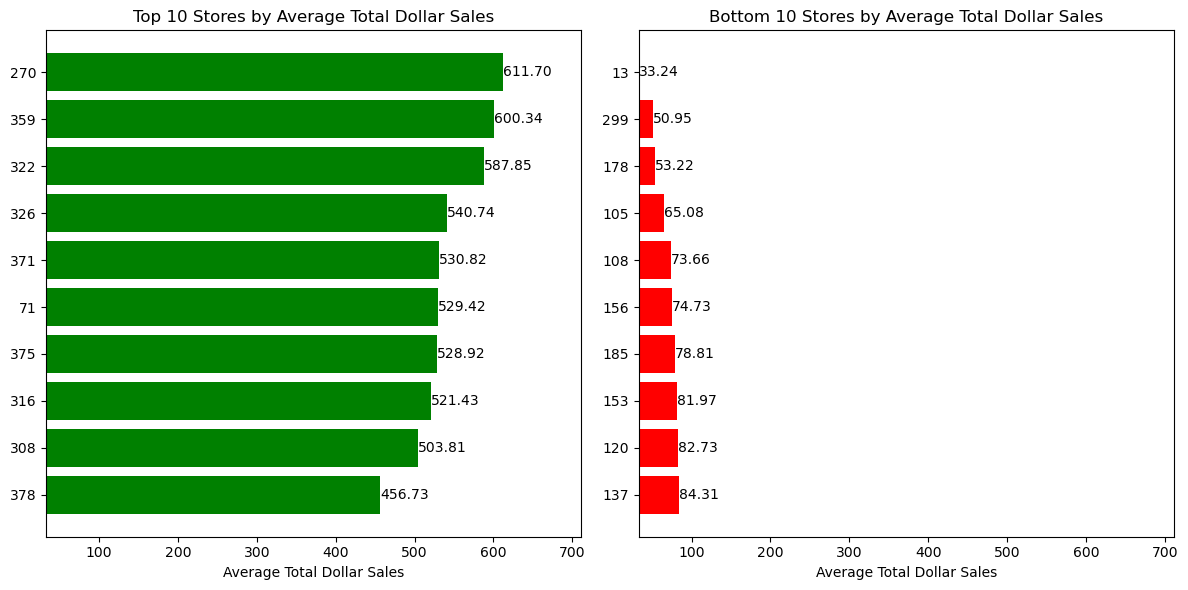

In [79]:
df = totel_store_by_week

df['store'] = df['store'].astype(str)
store_avg_sales = df.groupby('store')['totel_dollar_sales'].mean().reset_index()

top_10_stores = store_avg_sales.nlargest(10, 'totel_dollar_sales')
bottom_10_stores = store_avg_sales.nsmallest(10, 'totel_dollar_sales')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# หาขอบเขต x-axis สูงสุดและต่ำสุดเพื่อให้ใช้ค่าเดียวกันในทั้งสองกราฟ
max_x_value = max(top_10_stores['totel_dollar_sales'].max(), bottom_10_stores['totel_dollar_sales'].max())
min_x_value = min(top_10_stores['totel_dollar_sales'].min(), bottom_10_stores['totel_dollar_sales'].min())

# กราฟแสดงยอดขายสูงสุด 10 อันดับ
axes[0].barh(top_10_stores['store'], top_10_stores['totel_dollar_sales'], color='green')
axes[0].set_title('Top 10 Stores by Average Total Dollar Sales')
axes[0].set_xlabel('Average Total Dollar Sales')
axes[0].invert_yaxis()  # เรียงจากมากไปน้อย
axes[0].set_xlim(min_x_value, max_x_value)  # ตั้งค่าสเกลแกน X เท่ากัน

# เพิ่ม Label
for index, value in enumerate(top_10_stores['totel_dollar_sales']):
    axes[0].text(value, index, f'{value:.2f}', va='center')
    axes[0].set_xlim(min_x_value, max_x_value+100)  # ตั้งค่าสเกลแกน X เท่ากัน

# กราฟแสดงยอดขายต่ำสุด 10 อันดับ
axes[1].barh(bottom_10_stores['store'], bottom_10_stores['totel_dollar_sales'], color='red')
axes[1].set_title('Bottom 10 Stores by Average Total Dollar Sales')
axes[1].set_xlabel('Average Total Dollar Sales')
axes[1].invert_yaxis()  
axes[1].set_xlim(min_x_value, max_x_value+100)  # ตั้งค่าสเกลแกน X เท่ากัน

# เพิ่ม Label
for index, value in enumerate(bottom_10_stores['totel_dollar_sales']):
    axes[1].text(value, index, f'{value:.2f}', va='center')

plt.tight_layout()
plt.show()

- แสดงความสามารถในการทำยอดขายของแต่ละร้าน
- แนวโน้มของรายได้ในร้านแต่ละร้าน
- ขอบเขตที่ร้านค้าหนึ่งๆ น่าจะสามารถทำได้ เช่น ถ้าว่าแผนจะสร้างร้านใหม่อาจจะประมาณการณืว่าจะมีรายได้ในช่วง 33-611 dollar ต่อสัปดาห์

#### ที่ยังไม่ได้ทำแต่ส่วนใหญ่จะมี DataFrame ที่เตรียมไปแล้ว  

1) การจัดกลุ่มลูกค้า segmentation
  - น่าจะจัดแบบเป็น 
        HighValue : Household ที่ มีทั้ง Dollas_sales เกิน Upper_Outlier เป็นกลุ่มที่น่าสนใจ ไม่ว่าจะเป็นในแง่มูลค่าหรือตัวตนของลูกค้า
        Frequency : Household ใด ๆ ที่มีข้อมูล Basket เยอะกว่า Mean or Median ถือเป็นลูกค้าประจำ
        Common    : ลูกค้าทั่วไปที่ไม่เข้าเงื่อนไข 2 กลุ่มแรก และ มี last_day ไม่เกิน 365 วัน
        Churned   : ลูกค้าที่มี last_day เกิน 365 วัน
        
2) ดูความสัมพันธ์กลุ่มลูกค้ากับการใช้คูปอง

3) เปอร์เซนต์การเปลี่ยนแปลง หลังจากเปลี่ยนการจัดแสดงสินค้าในแต่ละสัปดาห์ เช่น ย้ายจาก A -> B แล้วยอดขายดีขึ้นกี่เปอร์เซ็น

4) ความสัมพัน์ระหว่างคูปองและเวลา เช่น วันที่มีการใช้คูปองเยอะที่สุด

5) วิเคราะห์สินค้าที่มักจะถูกซื้อด้วยกันเพื่อทำโปรโมชั้น

6) แนวโน้มยอดขายตามเวลา เช่น ตาม week

7) วิเคราะห์แนวโน้มยอดขาย, การจัดแสดงสินค้า, พฤติกรรมผู้บริโภค แยกตามพื้นที่ 

8) สินค้าที่ขายได้น้อยหรือไม่ได้ เพื่อพิจรณา ถอดออก หรือสต๊อก

9) แนวโน้มสินค้าเพื่อการสต๊อกของ

10) อยากทำ Meta data ตั้งแต่ data set ต้นฉบับล่ะ แล้วก็พวก Data Frame ที่สร้างมาทีหลังด้วย

11) Area: ความนิยมสินค้า